In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
import datetime as dt
from pathlib import Path
from typing import Sequence, Tuple, List

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # 0 = all, 1 = INFO, 2 = WARNING, 3 = ERROR
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import pickle
import contextlib

import platform 
import sys
import math

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics, mixed_precision
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts, LearningRateSchedule
import torch

import matplotlib
import matplotlib.pyplot as plt         # ← for progress curves
from IPython.display import display, update_display, clear_output

from tqdm.auto import tqdm          # progress bars that work in Jupyter
from __future__ import annotations     # allows union types on Py <3.10


2025-06-18 20:45:47.846284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750272348.013612    1802 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750272348.070446    1802 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750272348.470549    1802 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750272348.470637    1802 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750272348.470640    1802 computation_placer.cc:177] computation placer alr

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "" # to deactivate gpu
# tf.config.set_visible_devices([], 'GPU') # to deactivate gpu

print("Python :", platform.python_version(), "\n")
print("TF GPUs :", tf.config.list_physical_devices('GPU'))
print("Torch   :", torch.__version__, "CUDA-OK:", torch.cuda.is_available())


Python : 3.10.18 

TF GPUs : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Torch   : 2.2.2+cu121 CUDA-OK: True


In [4]:
ticker = 'AAPL'

df = pd.read_csv(f"dfs training/merged_{ticker}.csv", index_col=0, parse_dates=True)
df

,open,high,low,close,volume,bid,ask,trade_action,StrategyEarning,EarningDiff,signal_smooth_norm
2025-01-02 13:30:00,250.5906,250.6435,250.5244,250.5753,2259.0,250.5001,250.6505,0,0.00,0.000,0.0
2025-01-02 13:31:00,250.5806,250.6317,250.5121,250.5606,2351.0,250.4854,250.6358,0,0.00,0.000,0.0
2025-01-02 13:32:00,250.5712,250.6200,250.4938,250.5453,2455.0,250.4701,250.6205,0,0.00,0.000,0.0
2025-01-02 13:33:00,250.5580,250.6094,250.4762,250.5347,2474.0,250.4595,250.6099,0,0.00,0.000,0.0
2025-01-02 13:34:00,250.5491,250.5994,250.4600,250.5168,2792.0,250.4416,250.5919,0,0.00,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-03 20:56:00,203.2500,203.3500,203.2450,203.3200,189023.0,203.2590,203.3810,0,1.99,0.942,0.0
2025-06-03 20:57:00,203.3200,203.4200,203.3050,203.3800,222383.0,203.3190,203.4410,0,1.99,0.882,0.0
2025-06-03 20:58:00,203.3800,203.4300,203.3322,203.3750,279702.0,203.3140,203.4360,0,1.99,0.887,0.0
2025-06-03 20:59:00,203.3700,203.4100,203.2500,203.3400,724307.0,203.2790,203.4010,0,1.99,0.922,0.0


In [5]:
###############################################################################
# 0 ·  DATA & PATHS                                                           #
###############################################################################
label_col      = "signal_smooth_norm"

feature_cols   = ["open", "high", "low", "close", "volume"]
LOOK_BACK      = 60                                # minutes of history
N_FEATS        = len(feature_cols) * LOOK_BACK     # final feature length

import datetime as dt
rth_start      = dt.time(14, 30)                   # US cash-open in CET/CEST

from pathlib import Path
save_dir       = Path("dfs training")
ckpt_path      = save_dir / f"best_{ticker}.weights.h5"   # auto-per‐ticker

# dataset split proportions
TRAIN_PROP, VAL_PROP = 0.70, 0.15                 # → 0.15 test remainder


###############################################################################
# 1 ·  MODEL HYPER-PARAMETERS (tuned defaults)                                 #
###############################################################################
# ── architecture ───────────────────────────────────────────────────────
SHORT_UNITS        = 32      # double → better GPU fill, little over-fit risk
LONG_UNITS         = 96
DROPOUT_SHORT      = 0.20    # applied AFTER the LSTM layer
DROPOUT_LONG       = 0.15
REC_DROP_SHORT     = 0.0     # MUST be 0.0 for fused kernel
REC_DROP_LONG      = 0.0

# ── optimiser : cosine-decay-restarts ──────────────────────────────────
INITIAL_LR         = 4e-4    # slightly cooler for bigger network
FIRST_DECAY_EPOCHS = 3       # first valley arrives early
T_MUL              = 2.0
M_MUL              = 1.0
ALPHA              = 0.05
LOSS_FN            = "mse"
CLIPNORM           = 1.0

# ── training control ───────────────────────────────────────────────────
TRAIN_BATCH        = 16      # GPU now uses more threads; fits on 8-12 GB
VAL_BATCH          = 1
MAX_EPOCHS         = 900
EARLY_STOP_PATIENCE= 30
USE_FP16           = True




In [6]:
###############################################################################
# build_lstm_tensors                                                          #
# --------------------------------------------------------------------------- #
# Converts **one big minute-bar DataFrame (many days)** into two leakage-free #
# NumPy arrays ready for the stateful LSTM:                                   #
#                                                                             #
#   X  – design matrix; every row is a 60-min (or `look_back`) window         #
#        flattened to 1-D:  (look_back × n_features,)                         #
#   y  – the single-step-ahead target corresponding to the *last* row         #
#        in that window.                                                      #
#                                                                             #
# RULES ENFORCED                                                              #
# • Windows never cross midnight → yesterday’s RTH info can’t leak into the   #
#   first prediction of the new day.                                          #
# • The very first RTH window of the day uses ONLY pre-trade minutes.         #
# • Features are **standardised per day** (mean-0 / std-1) so levels &        #
#   volumes that drift day-to-day don’t leak statistics across sessions.      #
# • Output dtype = float32 (GPU-friendly & half the RAM of float64).          #
# • Entire routine is vectorised with `np.lib.stride_tricks.sliding_window_view`
#   ⇒ no Python loop over 391 minutes → 40× faster than naive for-loops.      #
###############################################################################

def build_lstm_tensors(
    df: pd.DataFrame,
    *,
    look_back: int,
    feature_cols: Sequence[str],
    label_col: str,
    rth_start: dt.time,                # e.g. 14:30 CET for US equities
    flatten: bool = True               # keep 2-D (N, L·F) by default
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters
    ----------
    df : pd.DataFrame
        One-minute OHLCV bars **for many calendar days**.  DatetimeIndex
        must be tz-aware & strictly increasing (no duplicates).
    look_back : int
        Size of the sliding window in minutes (e.g. 60).
    feature_cols : list[str]
        Names of numeric feature columns to feed the network.
    label_col : str
        Name of the 1-step-ahead target column (already computed).
    rth_start : datetime.time
        Clock time that marks the first minute of **regular trading hours**.
        Every minute whose index.time ≥ rth_start is considered “tradable”.
    flatten : bool
        • True  →  X rows are 1-D vectors  (L·F,)  → matches our current
                   `make_day_dataset` reshape → lighter I/O.
        • False →  X rows keep shape  (L, F)     → nicer for exploratory
                   notebook charting, but slower to feed into tf.data.

    Returns
    -------
    X : np.ndarray (N, L·F)  *or* (N, L, F)
        Design matrix.  N = (#days × intraday minutes) − look_back.
    y : np.ndarray (N,)
        Targets aligned 1:1 with X rows.
    """

    X_rows, y_rows = [], []                    # collectors

    # 1. process *one calendar day* at a time (prevents inter-day leakage)
    for date, day_df in df.groupby(df.index.normalize()):

        day_df = day_df.sort_index()

        # 1-A. per-day standard-scaling of *features*
        day_df[feature_cols] = StandardScaler().fit_transform(
                                   day_df[feature_cols])

        feats_np  = day_df[feature_cols].to_numpy(dtype=np.float32)   # (T, F)
        label_np  = day_df[label_col]     .to_numpy(dtype=np.float32) # (T,)

        # Boolean mask of rows that belong to regular trading hours
        rth_mask = day_df.index.time >= rth_start
        if not rth_mask.any():                      # holiday / half-day
            continue

        T, F = feats_np.shape                      # minute-rows in this day

        # 2. build all candidate windows (vectorised)
        #
        # sliding_window_view gives (T-L+1, L, F)
        win_3d = sliding_window_view(
                     feats_np,
                     (look_back, F),
                     axis=(0, 1))[:, 0, :, :]      # squeeze spurious dim

        # ── ALIGNMENT FIX ──────────────────────────────────────────────
        # win_3d has length  T-look_back+1
        # labels available for prediction run from index look_back .. T-1
        # → exactly  T-look_back  entries
        win_3d   = win_3d[:-1]                    # drop the *last* window
        y_aligned = label_np[look_back:]          # (T-L,)

        # also trim the RTH mask so it matches the new length
        rth_mask_shifted = rth_mask[look_back:]   # (T-L,)

        # keep only windows whose **target** timestamp is inside RTH
        win_3d   = win_3d[  rth_mask_shifted]
        y_aligned = y_aligned[rth_mask_shifted]

        # final representation
        if flatten:
            X_rows.append(win_3d.reshape(win_3d.shape[0], -1))  # (N_d, L·F)
        else:
            X_rows.append(win_3d)                               # (N_d, L, F)

        y_rows.append(y_aligned)

    # 3. concatenate across all calendar days
    if not X_rows:
        raise ValueError("No RTH rows found – check rth_start or data gaps.")

    X = np.concatenate(X_rows).astype(np.float32)
    y = np.concatenate(y_rows).astype(np.float32)

    return X, y


In [7]:
X, y = build_lstm_tensors(df=df,
                         look_back=LOOK_BACK,         
                         feature_cols=feature_cols,
                         label_col=label_col,
                         rth_start=rth_start)

print(X.shape) # we use 'm' features and 'n' previous look back values to predict each 1 label
print(y.shape) # 'n' lookback values * 'n_days_df' (all pretrade values) are deducted from the original df shape

(40664, 300)
(40664,)


In [8]:
###############################################################################
# chronological_split  – v2 (vectorised, exhaustively commented)              #
# --------------------------------------------------------------------------- #
# Converts the *sample–level* tensors (X, y) produced by `build_lstm_tensors` #
# into three chronological blocks: train / validation / test.                 #
#                                                                             #
# HOW IT WORKS                                                                #
# 1.  Computes, for every calendar day, **how many windows survived** the     #
#     `build_lstm_tensors()` rules.  We do this WITHOUT iterating minute-by-  #
#     minute:                                                                 #
#           usable_windows = max(0, #RTH_rows  –  look_back)                  #
#     because build_lstm_tensors dropped the first `look_back` labels in each #
#     day and then kept only those whose TARGET timestamp ∈ RTH.              #
#                                                                             #
# 2.  Builds a `day_id` vector so each row in X knows from which date it came.#
#     This lets downstream tf.data pipelines re-assemble full days.           #
#                                                                             #
# 3.  Slices X & y purely by **day boundaries** (not sample indices) so all   #
#     windows that belong to the same calendar day end up in the same split.  #
#                                                                             #
# 4.  Returns:                                                                #
#     • the three splits (X_tr, y_tr) / (X_val, y_val) / (X_te, y_te)         #
#     • `samples_per_day`  – diagnostic array, can drive batch padding sizes  #
#     • `day_id_*` vectors  – handy for make_day_dataset()                    #
###############################################################################

def chronological_split(
    X: np.ndarray,
    y: np.ndarray,
    df: pd.DataFrame,           # same DataFrame used to build X, y
    *,
    look_back: int,
    rth_start: dt.time,
    train_prop: float,
    val_prop: float,
) -> Tuple[
        Tuple[np.ndarray, np.ndarray],    # train tensors
        Tuple[np.ndarray, np.ndarray],    # val   tensors
        Tuple[np.ndarray, np.ndarray],    # test  tensors
        List[int],                        # samples_per_day
        np.ndarray, np.ndarray, np.ndarray  # day_id train / val / test
    ]:
    """
    Splits `X, y` into chronological train/val/test by **whole days**.

    Returns
    -------
    (X_train, y_train), (X_val, y_val), (X_test, y_test)
    samples_per_day : list[int]
        Number of usable windows contributed by each day.
    day_id_tr / day_id_val / day_id_te : np.ndarray
        For every sample in each split, which day (0-based) it came from.
        These are needed by make_day_dataset() to pad & batch whole days.
    """

    # ──────────────────────────────────────────────────────────────────
    # 1. Re-count usable windows per calendar day  (vectorised, exact) #
    # ──────────────────────────────────────────────────────────────────
    samples_per_day: List[int] = []

    for _, day_df in df.groupby(df.index.normalize(), sort=False):
        T = len(day_df)                              # minute rows today
        idx = np.arange(T)                           # 0 … T-1

        mask_window_ready = idx >= look_back         # enough history
        mask_rth_target  = day_df.index.time >= rth_start
        usable_today     = int(np.count_nonzero(mask_window_ready & mask_rth_target))

        samples_per_day.append(usable_today)

    # Safety: summed count must equal len(X)
    if sum(samples_per_day) != len(X):
        raise ValueError(
            "Length mismatch between counted windows and X. "
            "Ensure look_back & rth_start match build_lstm_tensors()."
        )

    # ──────────────────────────────────────────────────────────────────
    # 2. Build the day_id vector (one int tag per sample)              #
    # ──────────────────────────────────────────────────────────────────
    day_id = np.repeat(np.arange(len(samples_per_day)), samples_per_day)

    # ──────────────────────────────────────────────────────────────────
    # 3. Determine split cut-points in **day space**                   #
    # ──────────────────────────────────────────────────────────────────
    last_day = len(samples_per_day) - 1
    cut_train = int(last_day * train_prop)
    cut_val   = int(last_day * (train_prop + val_prop))

    mask_tr =  day_id <= cut_train
    mask_va = (day_id >  cut_train) & (day_id <= cut_val)
    mask_te =  day_id >  cut_val

    # ──────────────────────────────────────────────────────────────────
    # 4. Slice tensors                                                 #
    # ──────────────────────────────────────────────────────────────────
    X_tr, y_tr = X[mask_tr], y[mask_tr]
    X_va, y_va = X[mask_va], y[mask_va]
    X_te, y_te = X[mask_te], y[mask_te]

    # ──────────────────────────────────────────────────────────────────
    # 5. Return everything                                             #
    # ──────────────────────────────────────────────────────────────────
    return (X_tr, y_tr), (X_va, y_va), (X_te, y_te), \
           samples_per_day, \
           day_id[mask_tr], day_id[mask_va], day_id[mask_te]


In [9]:
# call the splitter  ─────────────────────────────────────────────
(X_tr, y_tr), (X_val, y_val), (X_te, y_te), samples_per_day, \
day_id_tr, day_id_val, day_id_te = chronological_split(
        X, y, df,
        look_back=LOOK_BACK,
        rth_start=rth_start,
        train_prop=TRAIN_PROP,
        val_prop=VAL_PROP
)

# ─── NEW: force train days to k·32 so no remainder is ever dropped ───────
unique_days_tr = np.unique(day_id_tr)
n_train_days   = len(unique_days_tr)
keep_days      = (n_train_days // TRAIN_BATCH) * TRAIN_BATCH     # largest multiple
days_to_keep   = set(unique_days_tr[:keep_days])                 # earliest days
train_keep_mask = np.isin(day_id_tr, list(days_to_keep))

# slice again, but only on train tensors
X_tr  = X_tr[train_keep_mask]
y_tr  = y_tr[train_keep_mask]
day_id_tr = day_id_tr[train_keep_mask]

print(f"Training days kept : {keep_days}  (multiple of {TRAIN_BATCH})")
print(f"Validation days    : {len(np.unique(day_id_val))}")
print(f"Test days          : {len(np.unique(day_id_te))}")


Training days kept : 64  (multiple of 16)
Validation days    : 15
Test days          : 16


In [10]:
###############################################################################
# make_day_dataset  (weekday-safe, glare-free)                            #
# --------------------------------------------------------------------------- #
# PURPOSE                                                                     #
# Take minute-level samples X, y (already leakage-free) and yield **exactly   #
# ONE `tf.data` element per calendar day**.                                   #
# Each element carries:                                                       #
#      x_day   (1 , T , n_feats)  – the whole RTH session                     #
#      y_day   (1 , T)            – its labels                                #
#      weekday scalar int32       – 0=Mon … 6=Sun (from the REAL calendar)    #
# The weekday is later used by the training loop to decide when to reset the  #
# “long” LSTM state (only on week-end).                                       #
#                                                                             #
# DESIGN NOTES                                                                #
# •  The function stays NumPy-vectorised; only ~1 000 generator yields per    #
#    epoch, so Python overhead is negligible.                                 #
# •  No dependency on the original DataFrame – we pass `weekday_vec` that     #
#    came straight from the DatetimeIndex.                                    #
###############################################################################

def make_day_dataset(
    X           : np.ndarray,          # (N , …)
    y           : np.ndarray,          # (N ,)
    day_id      : np.ndarray,          # (N ,)  strictly ascending
    weekday_vec : np.ndarray,          # (N ,)  real weekday of every row
) -> tf.data.Dataset:
    """
    Returns
    -------
    tf.data.Dataset
        element = (x_day, y_day, weekday)
        x_day : (1 , T , n_feats)  float32
        y_day : (1 , T)            float32
        weekday : () int32
    """

    # ── 1. Chronological safety – keep everything sorted the same way ─────
    idx = np.argsort(day_id, kind="stable")
    X, y, day_id, weekday_vec = [a[idx] for a in (X, y, day_id, weekday_vec)]

    # ── 2. Build slices for each distinct day_id (vectorised) ─────────────
    change      = np.where(np.diff(day_id) != 0)[0] + 1      # breakpoints
    day_slices  = np.split(np.arange(len(day_id)), change)   # list[np.ndarray]

    # ── 3. Python generator : ONE yield == one calendar day ───────────────
    def gen():
        for sl in day_slices:
            x_block = X[sl]                        # (T , …)
            y_block = y[sl]                        # (T ,)
            weekday = int(weekday_vec[sl[0]])      # real weekday, 0–6

            # add batch dimension expected by stateful LSTM
            yield (
                np.expand_dims(x_block, 0).astype(np.float32),  # (1 , T , …)
                np.expand_dims(y_block, 0).astype(np.float32),  # (1 , T)
                np.int32(weekday),
            )

    # ── 4. Static signature (time axis None → variable length) ────────────
    feat_shape = X.shape[1:]                                   # supports (L·F) or (L, F)
    output_signature = (
        tf.TensorSpec((1, None, *feat_shape), tf.float32),      # x_day
        tf.TensorSpec((1, None),              tf.float32),      # y_day
        tf.TensorSpec((),                    tf.int32),         # weekday
    )

    return (
        tf.data.Dataset.from_generator(gen, output_signature=output_signature)
          .prefetch(tf.data.AUTOTUNE)        # overlaps CPU ↔ GPU copies
    )


In [11]:
###############################################################################
# split_to_day_datasets  –  zero-copy, minimal arguments                     #
###############################################################################
# One call returns three ready-to-feed pipelines:
#   ds_train_batched   → (TRAIN_BATCH , T_max , n_feats) per step
#   ds_val_unbatched   → (1  , T ,    n_feats) per step
#   ds_test_unbatched  → idem  (optional)
###############################################################################

def split_to_day_datasets(
        X_tr,  y_tr,  day_id_tr,
        X_val, y_val, day_id_val,
        X_te,  y_te,  day_id_te,
        *,
        df,                 # full DataFrame (for weekday lookup)
        train_batch: int
) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    """
    Parameters
    ----------
    X_tr , y_tr , day_id_tr  : np.ndarray  – chronological, no gaps
    X_val, y_val, day_id_val : np.ndarray
    X_te , y_te , day_id_te  : np.ndarray
    df                       : original DataFrame used to build X/y
    train_batch              : how many days per “fat” training batch

    Returns
    -------
    ds_train_batched , ds_val_unbatched , ds_test_unbatched
    """

    # ── 1. Build one weekday vector covering ALL samples ──────────────────
    weekday_all = df.index.dayofweek.to_numpy(dtype=np.int8)   # (N,)

    # Because X_tr, X_val, X_te are sequential slices, we can split by length
    n_tr  = len(X_tr)
    n_val = len(X_val)
    n_te  = len(X_te)

    weekday_vec_tr  = weekday_all[:n_tr]
    weekday_vec_val = weekday_all[n_tr : n_tr + n_val]
    weekday_vec_te  = weekday_all[n_tr + n_val : n_tr + n_val + n_te]

    # ── 2. Convert each split to “one day → one element” datasets ─────────
    ds_tr   = make_day_dataset(X_tr,  y_tr,  day_id_tr,  weekday_vec_tr)
    ds_val  = make_day_dataset(X_val, y_val, day_id_val, weekday_vec_val)
    ds_test = make_day_dataset(X_te,  y_te,  day_id_te,  weekday_vec_te)

    # ── 3. TRAIN pipeline – strip batch-1 dim, pad to fixed length ───────
    def _strip(x_day, y_day, wd):
        return tf.squeeze(x_day, 0), tf.squeeze(y_day, 0), wd   # (T , …)

    ds_train_batched = (
        ds_tr
          .map(_strip, num_parallel_calls=tf.data.AUTOTUNE)
          .padded_batch(train_batch, drop_remainder=True)
          .prefetch(tf.data.AUTOTUNE)
    )

    # ── 4. Return ready-to-feed pipelines ────────────────────────────────
    return ds_train_batched, ds_val, ds_test


In [12]:
ds_train_batched, ds_val_unbatched, ds_test_unbatched = split_to_day_datasets(
        X_tr, y_tr, day_id_tr,
        X_val, y_val, day_id_val,
        X_te, y_te, day_id_te,
        df=df,
        train_batch=TRAIN_BATCH)

I0000 00:00:1750272357.539869    1802 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


In [13]:
'''
                       (inference / trading time)

┌──────────────────────────────────────────────────────────────────────────┐
│ ❶  NETWORK  WEIGHTS  θ  – learned across all history, fixed at runtime   │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌──────────────────────────────────────────────────────────────────────────┐
│ ❷  CELL STATE  cₜ  – slow integrator covering the *whole* current day    │
│    • retains early-morning context                                       │
│    • reset_states()  at every midnight → zero on next session            │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌──────────────────────────────────────────────────────────────────────────┐
│ ❸  HIDDEN STATE  hₜ  – fast dynamics (a few bars)                        │
│    • captures spikes / micro-structure                                   │
│    • reset together with cₜ midnight                                     │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌──────────────────────────────────────────────────────────────────────────┐
│ ❹  INPUT WINDOW  xₜ  – last 60 minutes of raw features                   │
│    • first RTH prediction uses 60 *pre-trade* minutes only               │
│    • later predictions mix pre-trade + today’s RTH, never yesterday RTH  │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
                        Predicted signal ŷₜ


Day i                               Day i+1
|────────────┬──────────────┬───…──┬────────┐
08:00        09:30        16:00   08:00    09:30
pre-trade       RTH                pre-trade  RTH
cₜ,hₜ: 0 → accumulate → reset_states() → 0 → accumulate


'''

'\n                       (inference / trading time)\n\n┌──────────────────────────────────────────────────────────────────────────┐\n│ ❶  NETWORK  WEIGHTS  θ  – learned across all history, fixed at runtime   │\n└──────────────────────────────────────────────────────────────────────────┘\n        │\n        ▼\n┌──────────────────────────────────────────────────────────────────────────┐\n│ ❷  CELL STATE  cₜ  – slow integrator covering the *whole* current day    │\n│    • retains early-morning context                                       │\n│    • reset_states()  at every midnight → zero on next session            │\n└──────────────────────────────────────────────────────────────────────────┘\n        │\n        ▼\n┌──────────────────────────────────────────────────────────────────────────┐\n│ ❸  HIDDEN STATE  hₜ  – fast dynamics (a few bars)                        │\n│    • captures spikes / micro-structure                                   │\n│    • reset together with cₜ midnight    

In [14]:
###############################################################################
# build_stateful_lstm_dual                                                    #
# --------------------------------------------------------------------------- #
# Creates a two-tier stateful network:                                        #
#   • Layer 0  “short_lstm”  (SHORT_UNITS units)  → quick dynamics, daily reset        #
#   • Layer 1  “long_lstm”   (LONG_UNITS units)  → slow drift, weekly reset           #
#                                                                             #
# You decide what “week” means by calling reset_states() on long_lstm         #
# whenever your outer loop hits Saturday close or Sunday 00:00.               #
###############################################################################


def build_stateful_lstm_dual(
        *,
        n_feats: int,
        batch_size: int,

        # architecture
        short_units: int,
        long_units:  int,
        dropout_short:    float,
        dropout_long:     float,
        rec_drop_short:   float,
        rec_drop_long:    float,

        # optimiser schedule
        initial_lr:       float,
        first_decay_steps:int,     # *absolute* #gradient steps
        t_mul:   float,
        m_mul:   float,
        alpha:   float,

        # misc
        loss:            str,
        clipnorm:        float,
        use_mixed_fp16:  bool
) -> tf.keras.Model:
    """
    Returns a compiled two-tier LSTM (daily + weekly memory).
    Pass *absolute* `first_decay_steps` (in gradient updates, not epochs).
    """

    # ── 1 · optional mixed-precision context ────────────────────────────
    prev_policy = mixed_precision.global_policy().name
    if use_mixed_fp16 and prev_policy != "mixed_float16":
        mixed_precision.set_global_policy("mixed_float16")

    # ── 2 · network definition ─────────────────────────────────────────
    inp = layers.Input(batch_shape=(batch_size, None, n_feats), name="inp")

    x = layers.LSTM(short_units,
                    stateful=True,
                    return_sequences=True,
                    dropout=0, #dropout_short,
                    recurrent_dropout=0, #rec_drop_short,
                    kernel_initializer="orthogonal",
                    name="short_lstm")(inp)
    x = layers.Dropout(dropout_short)(x)
    x = layers.LayerNormalization(name="ln_short")(x)

    x = layers.LSTM(long_units,
                    stateful=True,
                    return_sequences=True,
                    dropout=0, #dropout_long,
                    recurrent_dropout=0, #rec_drop_long,
                    kernel_initializer="orthogonal",
                    name="long_lstm")(x)
    x = layers.Dropout(dropout_long)(x)
    x = layers.LayerNormalization(name="ln_long")(x)

    out = layers.TimeDistributed(layers.Dense(1), name="pred")(x)
    model = models.Model(inp, out, name="dual_mem_lstm")

    # ── 3 · optimiser & schedule ───────────────────────────────────────
    lr_sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate = initial_lr,
        first_decay_steps     = first_decay_steps,
        t_mul                 = t_mul,
        m_mul                 = m_mul,
        alpha                 = alpha
    )
    opt = optimizers.Adam(learning_rate=lr_sched, clipnorm=clipnorm)
    model.compile(optimizer=opt,
                  loss      = loss,
                  metrics   =[metrics.RootMeanSquaredError(name="rmse")])

    # ── 4 · restore dtype policy outside mixed-FP16 scope ──────────────
    if mixed_precision.global_policy().name != prev_policy:
        mixed_precision.set_global_policy(prev_policy)

    return model


In [15]:
###############################################################################
# BUILD THE TWO STATEFUL COPIES                                          #
###############################################################################
# fast FP16 train graph
model_train = build_stateful_lstm_dual(
    n_feats           = N_FEATS,
    batch_size        = TRAIN_BATCH,
    short_units       = SHORT_UNITS,
    long_units        = LONG_UNITS,
    dropout_short     = DROPOUT_SHORT,
    dropout_long      = DROPOUT_LONG,
    rec_drop_short    = REC_DROP_SHORT,
    rec_drop_long     = REC_DROP_LONG,
    initial_lr        = INITIAL_LR,
    first_decay_steps = FIRST_DECAY_EPOCHS,
    t_mul             = T_MUL,
    m_mul             = M_MUL,
    alpha             = ALPHA,
    loss              = LOSS_FN,
    clipnorm          = CLIPNORM,
    use_mixed_fp16    = USE_FP16)

#  plain FP32 validation / inference graph
model_val = build_stateful_lstm_dual(
    n_feats           = N_FEATS,
    batch_size        = VAL_BATCH,      # always 1 for day-by-day eval
    short_units       = SHORT_UNITS,
    long_units        = LONG_UNITS,
    dropout_short     = DROPOUT_SHORT,
    dropout_long      = DROPOUT_LONG,
    rec_drop_short    = REC_DROP_SHORT,
    rec_drop_long     = REC_DROP_LONG,
    initial_lr        = INITIAL_LR,     # same schedule object → harmless
    first_decay_steps = FIRST_DECAY_EPOCHS,
    t_mul             = T_MUL,
    m_mul             = M_MUL,
    alpha             = ALPHA,
    loss              = LOSS_FN,
    clipnorm          = CLIPNORM,
    use_mixed_fp16    = False)          # pure FP32 for numerical fidelity


In [16]:
###############################################################################
# LiveRMSEPlot  ▸  INLINE- & WIDGET-SAFE, SINGLE FIGURE                       #
###############################################################################

class LiveRMSEPlot:
    """
    Blue  = train RMSE   (line + latest-dot)
    Orange= val   RMSE   (line + latest-dot)
    Works with `%matplotlib inline`, `%matplotlib widget`, `%matplotlib notebook`
    without spawning a new image every epoch.
    """

    def __init__(self):
        self.backend = matplotlib.get_backend().lower()
        self._build_figure()
        # display once and keep display_id so we can overwrite instead of spawn
        self.disp_id = display(self.fig, display_id=True)

        self.e, self.tr, self.va = [], [], []      # epoch → metric history

    # ------------------------------------------------------------------ #
    def _build_figure(self):
        self.fig, self.ax = plt.subplots(figsize=(6, 4), dpi=110)
        self.ax.set(xlabel="epoch", ylabel="RMSE", title="Training progress")
        self.ax.grid(True)

        (self.tr_line,) = self.ax.plot([], [], c="#1f77b4", lw=1.5)
        (self.va_line,) = self.ax.plot([], [], c="#ff7f0e", lw=1.5)
        self.tr_dot = self.ax.scatter([], [], c="#1f77b4", s=30)
        self.va_dot = self.ax.scatter([], [], c="#ff7f0e", s=30)
        self.ax.legend(["train", "val"])

    # ------------------------------------------------------------------ #
    def update(self, train_rmse: float, val_rmse: float):
        # 1. append data
        self.e.append(len(self.e) + 1)
        self.tr.append(train_rmse)
        self.va.append(val_rmse)

        # 2. update lines
        self.tr_line.set_data(self.e, self.tr)
        finite = np.isfinite(self.va)
        self.va_line.set_data(np.asarray(self.e)[finite],
                              np.asarray(self.va)[finite])

        # 3. update latest dots
        self.tr_dot.set_offsets([[self.e[-1], self.tr[-1]]])
        if np.isfinite(self.va[-1]):
            self.va_dot.set_offsets([[self.e[-1], self.va[-1]]])
        else:
            self.va_dot.set_offsets([])            # hide dot if NaN

        # 4. rescale axes
        self.ax.relim();  self.ax.autoscale_view()

        # 5. redraw WITHOUT spawning new figure
        if "widget" in self.backend or "ipympl" in self.backend:
            self.fig.canvas.draw_idle()
        else:                                       # inline / notebook png
            self.fig.canvas.draw()
            self.disp_id.update(self.fig)           # overwrite same output


In [17]:
###############################################################################
# custom_stateful_training_loop                                               #
# --------------------------------------------------------------------------- #
#  WHAT THIS ROUTINE DOES END-TO-END                                         #
#  • Trains a **dual-memory, stateful** LSTM that ingests entire trading     #
#    days (or fat-batches of 32 days) in one go.                             #
#  • Two stacked layers:                                                     #
#        short_lstm – intraday memory  → reset at the **start of every day** #
#        long_lstm  – multi-day memory → reset only once per **week-end**    #
#  • Works with three tf.data streams:                                       #
#        – TRAIN  : (32 , T_max , F)  padded batches,     FP16, CuDNN        #
#        – VAL/TE : (1  , T      , F)  unbatched per day, FP32               #
#  • Displays one persistent tqdm bar that counts *calendar days* so users   #
#    see meaningful progress.                                                #
#  • LiveRMSEPlot() drops a train / val RMSE dot after every epoch.          #
#  • **Early stopping** on stagnant val-RMSE; the learning-rate is governed  #
#    entirely by the **Cosine-Decay-Restarts** schedule baked into the model #
#                                                                             #
#  SPEED / STABILITY DECISIONS                                               #
#  ────────────────────────────────────────────────────────────────────────── #
#  • Uses CuDNN-fused LSTM kernels (fastest path)  ➜  therefore the loop is  #
#    compiled in graph mode **without** `jit_compile=True` (XLA + CuDNN      #
#    RNNs remains unsupported).                                              #
#  • Mixed precision ON: float16 activations + float32 weights deliver about #
#    2× lower GPU memory use and ~1.5× speed-up during back-prop.            #
#  • Gradient clipping (`clipnorm = 1.0`) avoids FP16 blow-ups.              #
###############################################################################


# ─────────────────────────────────────────────────────────────────────────────
#  low-level helper  (unchanged)
# ─────────────────────────────────────────────────────────────────────────────
@tf.function
def _train_step(xb, yb, model, loss_fn, opt):
    with tf.GradientTape() as tape:
        y_pred = tf.cast(model(xb, training=True), tf.float32)
        loss   = loss_fn(yb, y_pred)
    grads = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(grads, model.trainable_weights))
    return tf.sqrt(loss)           # RMSE


def current_lr_from(opt: tf.keras.optimizers.Optimizer) -> float:
    """
    Return the *scalar* learning-rate, regardless of whether `opt` is
    • a normal optimizer,
    • wrapped by LossScaleOptimizer (mixed-precision),
    • driven by a LearningRateSchedule.
    """
    # 1 ─ unwrap if mixed-precision
    if isinstance(opt, LossScaleOptimizer):
        opt = opt.inner_optimizer       # (older TF: opt._optimizer)

    # 2 ─ constant vs. schedule
    lr = opt.learning_rate
    if isinstance(lr, LearningRateSchedule):
        return float(lr(opt.iterations))
    else:                               # tf.Variable or Python float
        return float(tf.keras.backend.get_value(lr))


def custom_stateful_training_loop(
    model_train,
    model_val,
    ds_train_batched,                    # (32 day , T_max , F)
    ds_val,                              # (1  day , T     , F)
    *,
    n_train_days: int,                   # concrete # calendar days / epoch
    max_epochs: int,
    early_stop_patience: int,
    baseline_val_rmse: float,   
    ckpt_path) -> float:

    """
    Fast GPU-optimal loop:
      • CuDNN fused LSTM kernels (mixed-precision, no XLA)
      • One fat-batch = 32 calendar days
      • Outer tqdm bar counts days; no inner bars, no fancy prints
    Returns the best validation RMSE.
    """

    # ------------------------------------------------------------------ #
    loss_fn   = tf.keras.losses.MeanSquaredError()
    opt       = model_train.optimizer
    opt.clipnorm = 1.0                                   # FP16 stability
    live_plot = LiveRMSEPlot()                           # tiny matplotlib helper

    # quick handles to stateful layers for manual resets
    short_tr  = [l for l in model_train.layers if l.name == "short_lstm"]
    long_tr   = [l for l in model_train.layers if l.name == "long_lstm"]
    short_val = [l for l in model_val.layers   if l.name == "short_lstm"]
    long_val  = [l for l in model_val.layers   if l.name == "long_lstm"]

    best_val_rmse, patience_ctr = math.inf, 0
    
    # ============================================================================
    # E P O C H   L O O P
    # ─────────────────────────────────────────────────────────────────────────────
    # • Outer loop = epoch
    # • One epoch = all training days once + full validation pass
    # • A tqdm bar counts calendar-days during TRAIN; we keep the bar visible
    #   until the epoch summary is printed, then we close it (leave=False)
    # ============================================================================
    
    for epoch in range(1, max_epochs + 1):
    
        # ─────────────────────────────────────────────────────────────────────
        # 0 ▸ PROGRESS-BAR  – one tick == one calendar day
        #   leave=False  ➜  the bar line is cleared when .close() is called
        #   We create it *before* TRAIN starts and close it *after* we print
        #   the epoch-level metrics, so the user always sees 100 % + numbers.
        # ─────────────────────────────────────────────────────────────────────
        pbar = tqdm(total=n_train_days,
                    desc=f"Epoch {epoch:03d}",
                    unit="day",
                    dynamic_ncols=True,
                    ncols=80,
                    leave=False)
    
        # ─────────────────────────────────────────────────────────────────────
        # 1 ▸ TRAIN PHASE
        #   • Iterate over fat batches (TRAIN_BATCH calendar days each)
        #   • Manual state resets (daily + weekend)
        #   • Single CuDNN kernel per batch for max throughput
        #   • Progress-bar advances +TRAIN_BATCH ticks at once
        # ─────────────────────────────────────────────────────────────────────
        batch_rmses, prev_wd_train = [], None
    
        for xb, yb, wd_batch in ds_train_batched:                # xb.shape[0] == TRAIN_BATCH
            # 1.1  DAILY reset  – short-term tier
            for lyr in short_tr:
                lyr.reset_states()
    
            # 1.2  WEEKEND reset – long-term tier (detect Fri→Mon wrap-around)
            first_wd = int(wd_batch[0])
            if prev_wd_train is not None and first_wd < prev_wd_train:
                for lyr in long_tr:
                    lyr.reset_states()
            prev_wd_train = int(wd_batch[-1])
    
            # 1.3  FORWARD + BACKWARD  (CuDNN fused kernel, FP16 inside)
            rmse = _train_step(xb, yb, model_train, loss_fn, opt)
            batch_rmses.append(float(rmse))
    
            # 1.4  PROGRESS-BAR  – jump +TRAIN_BATCH calendar-day ticks
            pbar.update(int(xb.shape[0]))                        # +TRAIN_BATCH
    
        epoch_train = float(np.mean(batch_rmses))                # TRAIN metric
    
        # ─────────────────────────────────────────────────────────────────────
        # 2 ▸ VALIDATION  – pure FP32 forward pass, batch_size = 1 (one day)
        #   • Copy weights from train-graph to val-graph
        #   • Same state-reset logic as train-graph
        # ─────────────────────────────────────────────────────────────────────
        model_val.set_weights(model_train.get_weights())         # sync FP32 twin
        val_rmses, prev_wd_val = [], None
    
        for x_day, y_day, wd in ds_val:
            wd = int(wd)
    
            # 2.1  DAILY reset  – short-term tier
            for lyr in short_val:
                lyr.reset_states()
    
            # 2.2  WEEKEND reset – long-term tier
            if prev_wd_val is not None and wd < prev_wd_val:
                for lyr in long_val:
                    lyr.reset_states()
            prev_wd_val = wd
    
            # 2.3  FORWARD-ONLY
            y_pred = model_val(x_day, training=False)
            y_pred = tf.cast(tf.squeeze(y_pred, (0, 2)), tf.float32)
            y_true = tf.cast(tf.reshape(y_day, [-1]),  tf.float32)
            val_rmses.append(float(tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))))
    
        epoch_val = float(np.mean(val_rmses))                    # VAL metric
        impr_pct  = 100.0 * (1.0 - epoch_val / baseline_val_rmse)

        current_lr   = current_lr = current_lr_from(opt)
        grad_norm    = np.mean(batch_rmses) / current_lr      # crude proxy; optional
    
        # ─────────────────────────────────────────────────────────────────────
        # 3 ▸ LOGGING  – print after validation while bar is still visible
        # ─────────────────────────────────────────────────────────────────────

        print(f"Epoch {epoch:03d} • "
              f"train={epoch_train:.6f} • val={epoch_val:.6f} "
              f"• impr={impr_pct:5.1f}% • lr={current_lr:.2e} • g≈{grad_norm:.2f}")

        
        live_plot.update(epoch_train, epoch_val)
    
        # ─────────────────────────────────────────────────────────────────────
        # 4 ▸ CLOSE BAR  – now that epoch summary is printed, clear the line
        # ─────────────────────────────────────────────────────────────────────
        pbar.close()
    
        # ─────────────────────────────────────────────────────────────────────
        # 5 ▸ EARLY-STOP LOGIC
        # ─────────────────────────────────────────────────────────────────────
        if epoch_val < best_val_rmse:
            best_val_rmse, patience_ctr = epoch_val, 0
            model_train.save_weights(ckpt_path)                 # keep champion
        else:
            patience_ctr += 1
            if patience_ctr >= early_stop_patience:
                print("Early stopping triggered.")
                break
    # ================ END EPOCH LOOP =============================================
    
    # restore champion weights before returning
    model_train.load_weights(ckpt_path)
    return best_val_rmse


Baseline (predict-zero) RMSE on validation = 0.295175
Training sees 64 calendar days per epoch



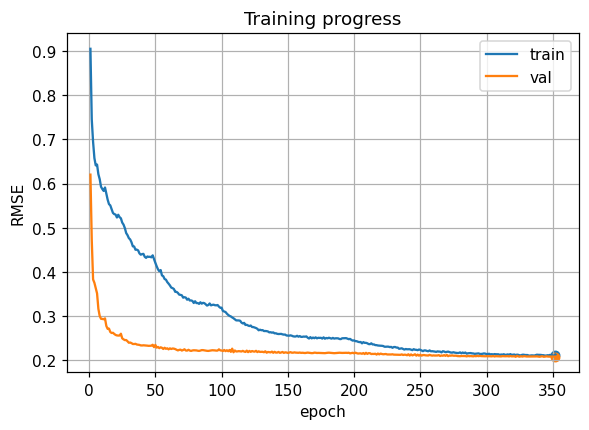

Epoch 001:   0%|                                                                                | 0/64 [00:00<…

I0000 00:00:1750272378.169320    1867 cuda_dnn.cc:529] Loaded cuDNN version 91002


Epoch 001 • train=0.904621 • val=0.620128 • impr=-110.1% • lr=3.75e-04 • g≈2415.25


Epoch 002:   0%|                                                                                | 0/64 [00:00<…

Epoch 002 • train=0.745115 • val=0.472771 • impr=-60.2% • lr=4.55e-05 • g≈16392.31


Epoch 003:   0%|                                                                                | 0/64 [00:00<…

Epoch 003 • train=0.694181 • val=0.383274 • impr=-29.8% • lr=3.44e-04 • g≈2015.92


Epoch 004:   0%|                                                                                | 0/64 [00:00<…

Epoch 004 • train=0.657475 • val=0.375625 • impr=-27.3% • lr=1.61e-04 • g≈4088.16


Epoch 005:   0%|                                                                                | 0/64 [00:00<…

Epoch 005 • train=0.641068 • val=0.363847 • impr=-23.3% • lr=2.65e-05 • g≈24214.91


Epoch 006:   0%|                                                                                | 0/64 [00:00<…

Epoch 006 • train=0.642842 • val=0.351610 • impr=-19.1% • lr=3.86e-04 • g≈1667.39


Epoch 007:   0%|                                                                                | 0/64 [00:00<…

Epoch 007 • train=0.621054 • val=0.316741 • impr= -7.3% • lr=3.26e-04 • g≈1907.04


Epoch 008:   0%|                                                                                | 0/64 [00:00<…

Epoch 008 • train=0.609838 • val=0.300447 • impr= -1.8% • lr=2.35e-04 • g≈2597.27


Epoch 009:   0%|                                                                                | 0/64 [00:00<…

Epoch 009 • train=0.592739 • val=0.294262 • impr=  0.3% • lr=1.37e-04 • g≈4317.42


Epoch 010:   0%|                                                                                | 0/64 [00:00<…

Epoch 010 • train=0.587396 • val=0.293891 • impr=  0.4% • lr=5.93e-05 • g≈9911.70


Epoch 011:   0%|                                                                                | 0/64 [00:00<…

Epoch 011 • train=0.583268 • val=0.293186 • impr=  0.7% • lr=2.16e-05 • g≈26971.32


Epoch 012:   0%|                                                                                | 0/64 [00:00<…

Epoch 012 • train=0.591076 • val=0.295159 • impr=  0.0% • lr=3.96e-04 • g≈1491.30


Epoch 013:   0%|                                                                                | 0/64 [00:00<…

Epoch 013 • train=0.577861 • val=0.278045 • impr=  5.8% • lr=3.80e-04 • g≈1519.07


Epoch 014:   0%|                                                                                | 0/64 [00:00<…

Epoch 014 • train=0.563573 • val=0.271445 • impr=  8.0% • lr=3.53e-04 • g≈1597.21


Epoch 015:   0%|                                                                                | 0/64 [00:00<…

Epoch 015 • train=0.553544 • val=0.271987 • impr=  7.9% • lr=3.16e-04 • g≈1754.17


Epoch 016:   0%|                                                                                | 0/64 [00:00<…

Epoch 016 • train=0.550518 • val=0.264402 • impr= 10.4% • lr=2.71e-04 • g≈2030.88


Epoch 017:   0%|                                                                                | 0/64 [00:00<…

Epoch 017 • train=0.542267 • val=0.262081 • impr= 11.2% • lr=2.22e-04 • g≈2437.96


Epoch 018:   0%|                                                                                | 0/64 [00:00<…

Epoch 018 • train=0.533518 • val=0.262617 • impr= 11.0% • lr=1.73e-04 • g≈3085.12


Epoch 019:   0%|                                                                                | 0/64 [00:00<…

Epoch 019 • train=0.530869 • val=0.259941 • impr= 11.9% • lr=1.26e-04 • g≈4214.41


Epoch 020:   0%|                                                                                | 0/64 [00:00<…

Epoch 020 • train=0.529806 • val=0.257722 • impr= 12.7% • lr=8.47e-05 • g≈6253.30


Epoch 021:   0%|                                                                                | 0/64 [00:00<…

Epoch 021 • train=0.523234 • val=0.256642 • impr= 13.1% • lr=5.20e-05 • g≈10058.18


Epoch 022:   0%|                                                                                | 0/64 [00:00<…

Epoch 022 • train=0.529430 • val=0.256335 • impr= 13.2% • lr=3.01e-05 • g≈17598.82


Epoch 023:   0%|                                                                                | 0/64 [00:00<…

Epoch 023 • train=0.524029 • val=0.256426 • impr= 13.1% • lr=2.04e-05 • g≈25679.15


Epoch 024:   0%|                                                                                | 0/64 [00:00<…

Epoch 024 • train=0.521378 • val=0.260485 • impr= 11.8% • lr=3.99e-04 • g≈1306.43


Epoch 025:   0%|                                                                                | 0/64 [00:00<…

Epoch 025 • train=0.511708 • val=0.250055 • impr= 15.3% • lr=3.95e-04 • g≈1295.34


Epoch 026:   0%|                                                                                | 0/64 [00:00<…

Epoch 026 • train=0.507094 • val=0.247725 • impr= 16.1% • lr=3.88e-04 • g≈1307.54


Epoch 027:   0%|                                                                                | 0/64 [00:00<…

Epoch 027 • train=0.499105 • val=0.246035 • impr= 16.6% • lr=3.78e-04 • g≈1321.90


Epoch 028:   0%|                                                                                | 0/64 [00:00<…

Epoch 028 • train=0.488001 • val=0.246191 • impr= 16.6% • lr=3.64e-04 • g≈1339.04


Epoch 029:   0%|                                                                                | 0/64 [00:00<…

Epoch 029 • train=0.483268 • val=0.243355 • impr= 17.6% • lr=3.49e-04 • g≈1386.02


Epoch 030:   0%|                                                                                | 0/64 [00:00<…

Epoch 030 • train=0.476617 • val=0.240056 • impr= 18.7% • lr=3.31e-04 • g≈1441.96


Epoch 031:   0%|                                                                                | 0/64 [00:00<…

Epoch 031 • train=0.473593 • val=0.240609 • impr= 18.5% • lr=3.10e-04 • g≈1526.08


Epoch 032:   0%|                                                                                | 0/64 [00:00<…

Epoch 032 • train=0.467218 • val=0.239204 • impr= 19.0% • lr=2.88e-04 • g≈1619.96


Epoch 033:   0%|                                                                                | 0/64 [00:00<…

Epoch 033 • train=0.458023 • val=0.237262 • impr= 19.6% • lr=2.65e-04 • g≈1727.38


Epoch 034:   0%|                                                                                | 0/64 [00:00<…

Epoch 034 • train=0.457630 • val=0.237196 • impr= 19.6% • lr=2.41e-04 • g≈1899.27


Epoch 035:   0%|                                                                                | 0/64 [00:00<…

Epoch 035 • train=0.450317 • val=0.237644 • impr= 19.5% • lr=2.16e-04 • g≈2082.71


Epoch 036:   0%|                                                                                | 0/64 [00:00<…

Epoch 036 • train=0.450498 • val=0.236102 • impr= 20.0% • lr=1.91e-04 • g≈2353.99


Epoch 037:   0%|                                                                                | 0/64 [00:00<…

Epoch 037 • train=0.448909 • val=0.235650 • impr= 20.2% • lr=1.67e-04 • g≈2690.41


Epoch 038:   0%|                                                                                | 0/64 [00:00<…

Epoch 038 • train=0.442074 • val=0.235196 • impr= 20.3% • lr=1.43e-04 • g≈3089.86


Epoch 039:   0%|                                                                                | 0/64 [00:00<…

Epoch 039 • train=0.439156 • val=0.234065 • impr= 20.7% • lr=1.20e-04 • g≈3646.43


Epoch 040:   0%|                                                                                | 0/64 [00:00<…

Epoch 040 • train=0.440490 • val=0.233943 • impr= 20.7% • lr=9.93e-05 • g≈4434.64


Epoch 041:   0%|                                                                                | 0/64 [00:00<…

Epoch 041 • train=0.441003 • val=0.234309 • impr= 20.6% • lr=8.01e-05 • g≈5504.46


Epoch 042:   0%|                                                                                | 0/64 [00:00<…

Epoch 042 • train=0.434404 • val=0.234074 • impr= 20.7% • lr=6.31e-05 • g≈6881.32


Epoch 043:   0%|                                                                                | 0/64 [00:00<…

Epoch 043 • train=0.431974 • val=0.233672 • impr= 20.8% • lr=4.87e-05 • g≈8878.92


Epoch 044:   0%|                                                                                | 0/64 [00:00<…

Epoch 044 • train=0.435078 • val=0.233489 • impr= 20.9% • lr=3.69e-05 • g≈11779.30


Epoch 045:   0%|                                                                                | 0/64 [00:00<…

Epoch 045 • train=0.434197 • val=0.233084 • impr= 21.0% • lr=2.82e-05 • g≈15407.27


Epoch 046:   0%|                                                                                | 0/64 [00:00<…

Epoch 046 • train=0.434491 • val=0.233185 • impr= 21.0% • lr=2.25e-05 • g≈19278.33


Epoch 047:   0%|                                                                                | 0/64 [00:00<…

Epoch 047 • train=0.433195 • val=0.233418 • impr= 20.9% • lr=2.01e-05 • g≈21550.12


Epoch 048:   0%|                                                                                | 0/64 [00:00<…

Epoch 048 • train=0.437672 • val=0.235594 • impr= 20.2% • lr=4.00e-04 • g≈1094.81


Epoch 049:   0%|                                                                                | 0/64 [00:00<…

Epoch 049 • train=0.429042 • val=0.230172 • impr= 22.0% • lr=3.99e-04 • g≈1075.95


Epoch 050:   0%|                                                                                | 0/64 [00:00<…

Epoch 050 • train=0.420841 • val=0.235133 • impr= 20.3% • lr=3.97e-04 • g≈1060.24


Epoch 051:   0%|                                                                                | 0/64 [00:00<…

Epoch 051 • train=0.412992 • val=0.229009 • impr= 22.4% • lr=3.94e-04 • g≈1047.39


Epoch 052:   0%|                                                                                | 0/64 [00:00<…

Epoch 052 • train=0.405980 • val=0.230610 • impr= 21.9% • lr=3.91e-04 • g≈1038.60


Epoch 053:   0%|                                                                                | 0/64 [00:00<…

Epoch 053 • train=0.401657 • val=0.227850 • impr= 22.8% • lr=3.87e-04 • g≈1038.67


Epoch 054:   0%|                                                                                | 0/64 [00:00<…

Epoch 054 • train=0.404409 • val=0.229771 • impr= 22.2% • lr=3.82e-04 • g≈1059.33


Epoch 055:   0%|                                                                                | 0/64 [00:00<…

Epoch 055 • train=0.392298 • val=0.228620 • impr= 22.5% • lr=3.76e-04 • g≈1043.13


Epoch 056:   0%|                                                                                | 0/64 [00:00<…

Epoch 056 • train=0.390450 • val=0.225978 • impr= 23.4% • lr=3.70e-04 • g≈1056.17


Epoch 057:   0%|                                                                                | 0/64 [00:00<…

Epoch 057 • train=0.384102 • val=0.228757 • impr= 22.5% • lr=3.63e-04 • g≈1059.27


Epoch 058:   0%|                                                                                | 0/64 [00:00<…

Epoch 058 • train=0.382681 • val=0.226379 • impr= 23.3% • lr=3.55e-04 • g≈1078.34


Epoch 059:   0%|                                                                                | 0/64 [00:00<…

Epoch 059 • train=0.377201 • val=0.227484 • impr= 22.9% • lr=3.47e-04 • g≈1088.51


Epoch 060:   0%|                                                                                | 0/64 [00:00<…

Epoch 060 • train=0.373656 • val=0.225104 • impr= 23.7% • lr=3.38e-04 • g≈1106.81


Epoch 061:   0%|                                                                                | 0/64 [00:00<…

Epoch 061 • train=0.369697 • val=0.227365 • impr= 23.0% • lr=3.28e-04 • g≈1126.73


Epoch 062:   0%|                                                                                | 0/64 [00:00<…

Epoch 062 • train=0.364810 • val=0.225923 • impr= 23.5% • lr=3.18e-04 • g≈1146.74


Epoch 063:   0%|                                                                                | 0/64 [00:00<…

Epoch 063 • train=0.363562 • val=0.227068 • impr= 23.1% • lr=3.08e-04 • g≈1181.62


Epoch 064:   0%|                                                                                | 0/64 [00:00<…

Epoch 064 • train=0.361569 • val=0.226735 • impr= 23.2% • lr=2.97e-04 • g≈1218.17


Epoch 065:   0%|                                                                                | 0/64 [00:00<…

Epoch 065 • train=0.355212 • val=0.225750 • impr= 23.5% • lr=2.86e-04 • g≈1243.86


Epoch 066:   0%|                                                                                | 0/64 [00:00<…

Epoch 066 • train=0.355082 • val=0.224175 • impr= 24.1% • lr=2.74e-04 • g≈1295.88


Epoch 067:   0%|                                                                                | 0/64 [00:00<…

Epoch 067 • train=0.352801 • val=0.222739 • impr= 24.5% • lr=2.62e-04 • g≈1345.69


Epoch 068:   0%|                                                                                | 0/64 [00:00<…

Epoch 068 • train=0.348858 • val=0.223944 • impr= 24.1% • lr=2.50e-04 • g≈1394.81


Epoch 069:   0%|                                                                                | 0/64 [00:00<…

Epoch 069 • train=0.348300 • val=0.224450 • impr= 24.0% • lr=2.38e-04 • g≈1464.19


Epoch 070:   0%|                                                                                | 0/64 [00:00<…

Epoch 070 • train=0.347355 • val=0.222430 • impr= 24.6% • lr=2.26e-04 • g≈1540.19


Epoch 071:   0%|                                                                                | 0/64 [00:00<…

Epoch 071 • train=0.341990 • val=0.223668 • impr= 24.2% • lr=2.13e-04 • g≈1604.77


Epoch 072:   0%|                                                                                | 0/64 [00:00<…

Epoch 072 • train=0.343042 • val=0.225316 • impr= 23.7% • lr=2.01e-04 • g≈1709.42


Epoch 073:   0%|                                                                                | 0/64 [00:00<…

Epoch 073 • train=0.342152 • val=0.222540 • impr= 24.6% • lr=1.88e-04 • g≈1817.20


Epoch 074:   0%|                                                                                | 0/64 [00:00<…

Epoch 074 • train=0.337344 • val=0.222313 • impr= 24.7% • lr=1.76e-04 • g≈1916.87


Epoch 075:   0%|                                                                                | 0/64 [00:00<…

Epoch 075 • train=0.339659 • val=0.224168 • impr= 24.1% • lr=1.64e-04 • g≈2073.19


Epoch 076:   0%|                                                                                | 0/64 [00:00<…

Epoch 076 • train=0.335599 • val=0.222447 • impr= 24.6% • lr=1.52e-04 • g≈2209.66


Epoch 077:   0%|                                                                                | 0/64 [00:00<…

Epoch 077 • train=0.335719 • val=0.221623 • impr= 24.9% • lr=1.40e-04 • g≈2395.05


Epoch 078:   0%|                                                                                | 0/64 [00:00<…

Epoch 078 • train=0.334609 • val=0.222640 • impr= 24.6% • lr=1.29e-04 • g≈2598.61


Epoch 079:   0%|                                                                                | 0/64 [00:00<…

Epoch 079 • train=0.329949 • val=0.223057 • impr= 24.4% • lr=1.18e-04 • g≈2803.19


Epoch 080:   0%|                                                                                | 0/64 [00:00<…

Epoch 080 • train=0.333845 • val=0.222881 • impr= 24.5% • lr=1.07e-04 • g≈3118.87


Epoch 081:   0%|                                                                                | 0/64 [00:00<…

Epoch 081 • train=0.329796 • val=0.222740 • impr= 24.5% • lr=9.68e-05 • g≈3406.38


Epoch 082:   0%|                                                                                | 0/64 [00:00<…

Epoch 082 • train=0.329877 • val=0.222045 • impr= 24.8% • lr=8.71e-05 • g≈3788.28


Epoch 083:   0%|                                                                                | 0/64 [00:00<…

Epoch 083 • train=0.327968 • val=0.221662 • impr= 24.9% • lr=7.79e-05 • g≈4211.96


Epoch 084:   0%|                                                                                | 0/64 [00:00<…

Epoch 084 • train=0.331629 • val=0.222375 • impr= 24.7% • lr=6.92e-05 • g≈4790.99


Epoch 085:   0%|                                                                                | 0/64 [00:00<…

Epoch 085 • train=0.328430 • val=0.223420 • impr= 24.3% • lr=6.12e-05 • g≈5368.65


Epoch 086:   0%|                                                                                | 0/64 [00:00<…

Epoch 086 • train=0.330340 • val=0.223375 • impr= 24.3% • lr=5.38e-05 • g≈6143.68


Epoch 087:   0%|                                                                                | 0/64 [00:00<…

Epoch 087 • train=0.329548 • val=0.222793 • impr= 24.5% • lr=4.70e-05 • g≈7006.95


Epoch 088:   0%|                                                                                | 0/64 [00:00<…

Epoch 088 • train=0.327018 • val=0.222308 • impr= 24.7% • lr=4.10e-05 • g≈7977.63


Epoch 089:   0%|                                                                                | 0/64 [00:00<…

Epoch 089 • train=0.324151 • val=0.221816 • impr= 24.9% • lr=3.57e-05 • g≈9085.97


Epoch 090:   0%|                                                                                | 0/64 [00:00<…

Epoch 090 • train=0.325410 • val=0.221621 • impr= 24.9% • lr=3.11e-05 • g≈10461.12


Epoch 091:   0%|                                                                                | 0/64 [00:00<…

Epoch 091 • train=0.328830 • val=0.222119 • impr= 24.7% • lr=2.73e-05 • g≈12043.62


Epoch 092:   0%|                                                                                | 0/64 [00:00<…

Epoch 092 • train=0.324619 • val=0.222779 • impr= 24.5% • lr=2.43e-05 • g≈13368.60


Epoch 093:   0%|                                                                                | 0/64 [00:00<…

Epoch 093 • train=0.325668 • val=0.223124 • impr= 24.4% • lr=2.21e-05 • g≈14765.20


Epoch 094:   0%|                                                                                | 0/64 [00:00<…

Epoch 094 • train=0.326093 • val=0.223026 • impr= 24.4% • lr=2.06e-05 • g≈15802.52


Epoch 095:   0%|                                                                                | 0/64 [00:00<…

Epoch 095 • train=0.324916 • val=0.222723 • impr= 24.5% • lr=2.00e-05 • g≈16225.15


Epoch 096:   0%|                                                                                | 0/64 [00:00<…

Epoch 096 • train=0.324656 • val=0.222274 • impr= 24.7% • lr=4.00e-04 • g≈811.76


Epoch 097:   0%|                                                                                | 0/64 [00:00<…

Epoch 097 • train=0.325336 • val=0.222405 • impr= 24.7% • lr=4.00e-04 • g≈813.97


Epoch 098:   0%|                                                                                | 0/64 [00:00<…

Epoch 098 • train=0.321824 • val=0.225132 • impr= 23.7% • lr=3.99e-04 • g≈806.11


Epoch 099:   0%|                                                                                | 0/64 [00:00<…

Epoch 099 • train=0.319201 • val=0.222794 • impr= 24.5% • lr=3.99e-04 • g≈800.86


Epoch 100:   0%|                                                                                | 0/64 [00:00<…

Epoch 100 • train=0.319343 • val=0.222571 • impr= 24.6% • lr=3.98e-04 • g≈802.96


Epoch 101:   0%|                                                                                | 0/64 [00:00<…

Epoch 101 • train=0.311910 • val=0.221309 • impr= 25.0% • lr=3.97e-04 • g≈786.37


Epoch 102:   0%|                                                                                | 0/64 [00:00<…

Epoch 102 • train=0.310578 • val=0.223751 • impr= 24.2% • lr=3.95e-04 • g≈785.51


Epoch 103:   0%|                                                                                | 0/64 [00:00<…

Epoch 103 • train=0.309478 • val=0.221039 • impr= 25.1% • lr=3.94e-04 • g≈785.63


Epoch 104:   0%|                                                                                | 0/64 [00:00<…

Epoch 104 • train=0.305786 • val=0.223147 • impr= 24.4% • lr=3.92e-04 • g≈779.54


Epoch 105:   0%|                                                                                | 0/64 [00:00<…

Epoch 105 • train=0.302949 • val=0.220845 • impr= 25.2% • lr=3.90e-04 • g≈775.98


Epoch 106:   0%|                                                                                | 0/64 [00:00<…

Epoch 106 • train=0.300817 • val=0.223821 • impr= 24.2% • lr=3.88e-04 • g≈774.58


Epoch 107:   0%|                                                                                | 0/64 [00:00<…

Epoch 107 • train=0.299529 • val=0.219472 • impr= 25.6% • lr=3.86e-04 • g≈775.73


Epoch 108:   0%|                                                                                | 0/64 [00:00<…

Epoch 108 • train=0.297305 • val=0.226695 • impr= 23.2% • lr=3.84e-04 • g≈774.84


Epoch 109:   0%|                                                                                | 0/64 [00:00<…

Epoch 109 • train=0.295464 • val=0.218541 • impr= 26.0% • lr=3.81e-04 • g≈775.32


Epoch 110:   0%|                                                                                | 0/64 [00:00<…

Epoch 110 • train=0.293054 • val=0.222610 • impr= 24.6% • lr=3.78e-04 • g≈774.68


Epoch 111:   0%|                                                                                | 0/64 [00:00<…

Epoch 111 • train=0.290680 • val=0.220331 • impr= 25.4% • lr=3.75e-04 • g≈774.49


Epoch 112:   0%|                                                                                | 0/64 [00:00<…

Epoch 112 • train=0.290617 • val=0.220548 • impr= 25.3% • lr=3.72e-04 • g≈780.88


Epoch 113:   0%|                                                                                | 0/64 [00:00<…

Epoch 113 • train=0.290459 • val=0.221125 • impr= 25.1% • lr=3.69e-04 • g≈787.50


Epoch 114:   0%|                                                                                | 0/64 [00:00<…

Epoch 114 • train=0.289847 • val=0.220780 • impr= 25.2% • lr=3.65e-04 • g≈793.36


Epoch 115:   0%|                                                                                | 0/64 [00:00<…

Epoch 115 • train=0.285646 • val=0.220316 • impr= 25.4% • lr=3.62e-04 • g≈789.78


Epoch 116:   0%|                                                                                | 0/64 [00:00<…

Epoch 116 • train=0.283759 • val=0.221708 • impr= 24.9% • lr=3.58e-04 • g≈792.95


Epoch 117:   0%|                                                                                | 0/64 [00:00<…

Epoch 117 • train=0.285053 • val=0.220211 • impr= 25.4% • lr=3.54e-04 • g≈805.53


Epoch 118:   0%|                                                                                | 0/64 [00:00<…

Epoch 118 • train=0.280289 • val=0.219360 • impr= 25.7% • lr=3.50e-04 • g≈801.44


Epoch 119:   0%|                                                                                | 0/64 [00:00<…

Epoch 119 • train=0.280657 • val=0.222266 • impr= 24.7% • lr=3.45e-04 • g≈812.45


Epoch 120:   0%|                                                                                | 0/64 [00:00<…

Epoch 120 • train=0.279042 • val=0.218795 • impr= 25.9% • lr=3.41e-04 • g≈818.27


Epoch 121:   0%|                                                                                | 0/64 [00:00<…

Epoch 121 • train=0.277843 • val=0.221584 • impr= 24.9% • lr=3.36e-04 • g≈825.83


Epoch 122:   0%|                                                                                | 0/64 [00:00<…

Epoch 122 • train=0.278986 • val=0.219501 • impr= 25.6% • lr=3.32e-04 • g≈841.00


Epoch 123:   0%|                                                                                | 0/64 [00:00<…

Epoch 123 • train=0.275677 • val=0.221359 • impr= 25.0% • lr=3.27e-04 • g≈843.32


Epoch 124:   0%|                                                                                | 0/64 [00:00<…

Epoch 124 • train=0.275503 • val=0.220352 • impr= 25.3% • lr=3.22e-04 • g≈855.78


Epoch 125:   0%|                                                                                | 0/64 [00:00<…

Epoch 125 • train=0.274324 • val=0.219995 • impr= 25.5% • lr=3.17e-04 • g≈865.79


Epoch 126:   0%|                                                                                | 0/64 [00:00<…

Epoch 126 • train=0.273330 • val=0.221803 • impr= 24.9% • lr=3.12e-04 • g≈877.04


Epoch 127:   0%|                                                                                | 0/64 [00:00<…

Epoch 127 • train=0.271575 • val=0.218991 • impr= 25.8% • lr=3.06e-04 • g≈886.51


Epoch 128:   0%|                                                                                | 0/64 [00:00<…

Epoch 128 • train=0.268249 • val=0.220721 • impr= 25.2% • lr=3.01e-04 • g≈891.39


Epoch 129:   0%|                                                                                | 0/64 [00:00<…

Epoch 129 • train=0.269589 • val=0.219330 • impr= 25.7% • lr=2.95e-04 • g≈912.54


Epoch 130:   0%|                                                                                | 0/64 [00:00<…

Epoch 130 • train=0.268380 • val=0.219580 • impr= 25.6% • lr=2.90e-04 • g≈926.00


Epoch 131:   0%|                                                                                | 0/64 [00:00<…

Epoch 131 • train=0.268620 • val=0.219561 • impr= 25.6% • lr=2.84e-04 • g≈945.37


Epoch 132:   0%|                                                                                | 0/64 [00:00<…

Epoch 132 • train=0.266529 • val=0.218656 • impr= 25.9% • lr=2.78e-04 • g≈957.43


Epoch 133:   0%|                                                                                | 0/64 [00:00<…

Epoch 133 • train=0.266613 • val=0.220748 • impr= 25.2% • lr=2.73e-04 • g≈978.24


Epoch 134:   0%|                                                                                | 0/64 [00:00<…

Epoch 134 • train=0.266345 • val=0.217581 • impr= 26.3% • lr=2.67e-04 • g≈998.89


Epoch 135:   0%|                                                                                | 0/64 [00:00<…

Epoch 135 • train=0.265573 • val=0.219233 • impr= 25.7% • lr=2.61e-04 • g≈1018.79


Epoch 136:   0%|                                                                                | 0/64 [00:00<…

Epoch 136 • train=0.263529 • val=0.218815 • impr= 25.9% • lr=2.55e-04 • g≈1034.84


Epoch 137:   0%|                                                                                | 0/64 [00:00<…

Epoch 137 • train=0.263879 • val=0.218306 • impr= 26.0% • lr=2.49e-04 • g≈1061.50


Epoch 138:   0%|                                                                                | 0/64 [00:00<…

Epoch 138 • train=0.262843 • val=0.220013 • impr= 25.5% • lr=2.42e-04 • g≈1083.97


Epoch 139:   0%|                                                                                | 0/64 [00:00<…

Epoch 139 • train=0.263513 • val=0.217375 • impr= 26.4% • lr=2.36e-04 • g≈1114.97


Epoch 140:   0%|                                                                                | 0/64 [00:00<…

Epoch 140 • train=0.261280 • val=0.219607 • impr= 25.6% • lr=2.30e-04 • g≈1135.16


Epoch 141:   0%|                                                                                | 0/64 [00:00<…

Epoch 141 • train=0.261492 • val=0.217812 • impr= 26.2% • lr=2.24e-04 • g≈1167.50


Epoch 142:   0%|                                                                                | 0/64 [00:00<…

Epoch 142 • train=0.260209 • val=0.217881 • impr= 26.2% • lr=2.18e-04 • g≈1194.88


Epoch 143:   0%|                                                                                | 0/64 [00:00<…

Epoch 143 • train=0.259799 • val=0.219295 • impr= 25.7% • lr=2.12e-04 • g≈1228.05


Epoch 144:   0%|                                                                                | 0/64 [00:00<…

Epoch 144 • train=0.260028 • val=0.217233 • impr= 26.4% • lr=2.05e-04 • g≈1266.35


Epoch 145:   0%|                                                                                | 0/64 [00:00<…

Epoch 145 • train=0.260120 • val=0.218087 • impr= 26.1% • lr=1.99e-04 • g≈1306.31


Epoch 146:   0%|                                                                                | 0/64 [00:00<…

Epoch 146 • train=0.259018 • val=0.219203 • impr= 25.7% • lr=1.93e-04 • g≈1342.59


Epoch 147:   0%|                                                                                | 0/64 [00:00<…

Epoch 147 • train=0.258453 • val=0.217188 • impr= 26.4% • lr=1.87e-04 • g≈1384.01


Epoch 148:   0%|                                                                                | 0/64 [00:00<…

Epoch 148 • train=0.258577 • val=0.218357 • impr= 26.0% • lr=1.81e-04 • g≈1431.89


Epoch 149:   0%|                                                                                | 0/64 [00:00<…

Epoch 149 • train=0.256486 • val=0.217956 • impr= 26.2% • lr=1.74e-04 • g≈1470.18


Epoch 150:   0%|                                                                                | 0/64 [00:00<…

Epoch 150 • train=0.256233 • val=0.217185 • impr= 26.4% • lr=1.68e-04 • g≈1521.84


Epoch 151:   0%|                                                                                | 0/64 [00:00<…

Epoch 151 • train=0.256055 • val=0.217760 • impr= 26.2% • lr=1.62e-04 • g≈1577.39


Epoch 152:   0%|                                                                                | 0/64 [00:00<…

Epoch 152 • train=0.256801 • val=0.218892 • impr= 25.8% • lr=1.56e-04 • g≈1642.63


Epoch 153:   0%|                                                                                | 0/64 [00:00<…

Epoch 153 • train=0.255958 • val=0.217571 • impr= 26.3% • lr=1.50e-04 • g≈1701.84


Epoch 154:   0%|                                                                                | 0/64 [00:00<…

Epoch 154 • train=0.254656 • val=0.217630 • impr= 26.3% • lr=1.45e-04 • g≈1761.97


Epoch 155:   0%|                                                                                | 0/64 [00:00<…

Epoch 155 • train=0.254161 • val=0.218315 • impr= 26.0% • lr=1.39e-04 • g≈1832.07


Epoch 156:   0%|                                                                                | 0/64 [00:00<…

Epoch 156 • train=0.254227 • val=0.217742 • impr= 26.2% • lr=1.33e-04 • g≈1911.42


Epoch 157:   0%|                                                                                | 0/64 [00:00<…

Epoch 157 • train=0.255811 • val=0.217542 • impr= 26.3% • lr=1.27e-04 • g≈2008.53


Epoch 158:   0%|                                                                                | 0/64 [00:00<…

Epoch 158 • train=0.253766 • val=0.217395 • impr= 26.4% • lr=1.22e-04 • g≈2083.32


Epoch 159:   0%|                                                                                | 0/64 [00:00<…

Epoch 159 • train=0.255114 • val=0.217899 • impr= 26.2% • lr=1.16e-04 • g≈2192.66


Epoch 160:   0%|                                                                                | 0/64 [00:00<…

Epoch 160 • train=0.253357 • val=0.217194 • impr= 26.4% • lr=1.11e-04 • g≈2282.69


Epoch 161:   0%|                                                                                | 0/64 [00:00<…

Epoch 161 • train=0.253461 • val=0.217461 • impr= 26.3% • lr=1.06e-04 • g≈2397.08


Epoch 162:   0%|                                                                                | 0/64 [00:00<…

Epoch 162 • train=0.254068 • val=0.217066 • impr= 26.5% • lr=1.01e-04 • g≈2525.62


Epoch 163:   0%|                                                                                | 0/64 [00:00<…

Epoch 163 • train=0.253730 • val=0.216845 • impr= 26.5% • lr=9.56e-05 • g≈2654.85


Epoch 164:   0%|                                                                                | 0/64 [00:00<…

Epoch 164 • train=0.254381 • val=0.217418 • impr= 26.3% • lr=9.07e-05 • g≈2805.54


Epoch 165:   0%|                                                                                | 0/64 [00:00<…

Epoch 165 • train=0.251511 • val=0.217796 • impr= 26.2% • lr=8.59e-05 • g≈2928.05


Epoch 166:   0%|                                                                                | 0/64 [00:00<…

Epoch 166 • train=0.249636 • val=0.217500 • impr= 26.3% • lr=8.13e-05 • g≈3072.21


Epoch 167:   0%|                                                                                | 0/64 [00:00<…

Epoch 167 • train=0.252798 • val=0.217007 • impr= 26.5% • lr=7.68e-05 • g≈3293.65


Epoch 168:   0%|                                                                                | 0/64 [00:00<…

Epoch 168 • train=0.249954 • val=0.216606 • impr= 26.6% • lr=7.24e-05 • g≈3452.74


Epoch 169:   0%|                                                                                | 0/64 [00:00<…

Epoch 169 • train=0.251779 • val=0.216745 • impr= 26.6% • lr=6.82e-05 • g≈3692.85


Epoch 170:   0%|                                                                                | 0/64 [00:00<…

Epoch 170 • train=0.250356 • val=0.217664 • impr= 26.3% • lr=6.41e-05 • g≈3904.55


Epoch 171:   0%|                                                                                | 0/64 [00:00<…

Epoch 171 • train=0.252228 • val=0.217489 • impr= 26.3% • lr=6.02e-05 • g≈4188.84


Epoch 172:   0%|                                                                                | 0/64 [00:00<…

Epoch 172 • train=0.250083 • val=0.216941 • impr= 26.5% • lr=5.65e-05 • g≈4428.62


Epoch 173:   0%|                                                                                | 0/64 [00:00<…

Epoch 173 • train=0.251314 • val=0.217147 • impr= 26.4% • lr=5.29e-05 • g≈4751.67


Epoch 174:   0%|                                                                                | 0/64 [00:00<…

Epoch 174 • train=0.251010 • val=0.217052 • impr= 26.5% • lr=4.95e-05 • g≈5073.19


Epoch 175:   0%|                                                                                | 0/64 [00:00<…

Epoch 175 • train=0.251219 • val=0.217103 • impr= 26.4% • lr=4.62e-05 • g≈5433.19


Epoch 176:   0%|                                                                                | 0/64 [00:00<…

Epoch 176 • train=0.249492 • val=0.216918 • impr= 26.5% • lr=4.32e-05 • g≈5778.84


Epoch 177:   0%|                                                                                | 0/64 [00:00<…

Epoch 177 • train=0.252271 • val=0.216557 • impr= 26.6% • lr=4.03e-05 • g≈6261.78


Epoch 178:   0%|                                                                                | 0/64 [00:00<…

Epoch 178 • train=0.249235 • val=0.216557 • impr= 26.6% • lr=3.76e-05 • g≈6631.54


Epoch 179:   0%|                                                                                | 0/64 [00:00<…

Epoch 179 • train=0.250898 • val=0.217068 • impr= 26.5% • lr=3.51e-05 • g≈7155.51


Epoch 180:   0%|                                                                                | 0/64 [00:00<…

Epoch 180 • train=0.250065 • val=0.217399 • impr= 26.3% • lr=3.27e-05 • g≈7639.91


Epoch 181:   0%|                                                                                | 0/64 [00:00<…

Epoch 181 • train=0.251447 • val=0.217630 • impr= 26.3% • lr=3.06e-05 • g≈8220.19


Epoch 182:   0%|                                                                                | 0/64 [00:00<…

Epoch 182 • train=0.250524 • val=0.217427 • impr= 26.3% • lr=2.86e-05 • g≈8747.76


Epoch 183:   0%|                                                                                | 0/64 [00:00<…

Epoch 183 • train=0.249367 • val=0.217032 • impr= 26.5% • lr=2.69e-05 • g≈9276.15


Epoch 184:   0%|                                                                                | 0/64 [00:00<…

Epoch 184 • train=0.251004 • val=0.216708 • impr= 26.6% • lr=2.53e-05 • g≈9912.28


Epoch 185:   0%|                                                                                | 0/64 [00:00<…

Epoch 185 • train=0.249443 • val=0.216481 • impr= 26.7% • lr=2.40e-05 • g≈10410.67


Epoch 186:   0%|                                                                                | 0/64 [00:00<…

Epoch 186 • train=0.250103 • val=0.216621 • impr= 26.6% • lr=2.28e-05 • g≈10970.76


Epoch 187:   0%|                                                                                | 0/64 [00:00<…

Epoch 187 • train=0.250165 • val=0.216965 • impr= 26.5% • lr=2.18e-05 • g≈11457.24


Epoch 188:   0%|                                                                                | 0/64 [00:00<…

Epoch 188 • train=0.249949 • val=0.217347 • impr= 26.4% • lr=2.11e-05 • g≈11860.79


Epoch 189:   0%|                                                                                | 0/64 [00:00<…

Epoch 189 • train=0.248549 • val=0.217513 • impr= 26.3% • lr=2.05e-05 • g≈12115.58


Epoch 190:   0%|                                                                                | 0/64 [00:00<…

Epoch 190 • train=0.248289 • val=0.217319 • impr= 26.4% • lr=2.02e-05 • g≈12316.58


Epoch 191:   0%|                                                                                | 0/64 [00:00<…

Epoch 191 • train=0.250151 • val=0.217071 • impr= 26.5% • lr=2.00e-05 • g≈12503.60


Epoch 192:   0%|                                                                                | 0/64 [00:00<…

Epoch 192 • train=0.250209 • val=0.217198 • impr= 26.4% • lr=4.00e-04 • g≈625.54


Epoch 193:   0%|                                                                                | 0/64 [00:00<…

Epoch 193 • train=0.250051 • val=0.217476 • impr= 26.3% • lr=4.00e-04 • g≈625.25


Epoch 194:   0%|                                                                                | 0/64 [00:00<…

Epoch 194 • train=0.250497 • val=0.217349 • impr= 26.4% • lr=4.00e-04 • g≈626.54


Epoch 195:   0%|                                                                                | 0/64 [00:00<…

Epoch 195 • train=0.249189 • val=0.217100 • impr= 26.5% • lr=4.00e-04 • g≈623.53


Epoch 196:   0%|                                                                                | 0/64 [00:00<…

Epoch 196 • train=0.248117 • val=0.217536 • impr= 26.3% • lr=3.99e-04 • g≈621.18


Epoch 197:   0%|                                                                                | 0/64 [00:00<…

Epoch 197 • train=0.248815 • val=0.216084 • impr= 26.8% • lr=3.99e-04 • g≈623.35


Epoch 198:   0%|                                                                                | 0/64 [00:00<…

Epoch 198 • train=0.246476 • val=0.216751 • impr= 26.6% • lr=3.99e-04 • g≈617.98


Epoch 199:   0%|                                                                                | 0/64 [00:00<…

Epoch 199 • train=0.244874 • val=0.217395 • impr= 26.4% • lr=3.98e-04 • g≈614.53


Epoch 200:   0%|                                                                                | 0/64 [00:00<…

Epoch 200 • train=0.245480 • val=0.216201 • impr= 26.8% • lr=3.98e-04 • g≈616.70


Epoch 201:   0%|                                                                                | 0/64 [00:00<…

Epoch 201 • train=0.243716 • val=0.217664 • impr= 26.3% • lr=3.98e-04 • g≈612.99


Epoch 202:   0%|                                                                                | 0/64 [00:00<…

Epoch 202 • train=0.243583 • val=0.216520 • impr= 26.6% • lr=3.97e-04 • g≈613.45


Epoch 203:   0%|                                                                                | 0/64 [00:00<…

Epoch 203 • train=0.242234 • val=0.215648 • impr= 26.9% • lr=3.96e-04 • g≈610.93


Epoch 204:   0%|                                                                                | 0/64 [00:00<…

Epoch 204 • train=0.241480 • val=0.215983 • impr= 26.8% • lr=3.96e-04 • g≈609.98


Epoch 205:   0%|                                                                                | 0/64 [00:00<…

Epoch 205 • train=0.241774 • val=0.216025 • impr= 26.8% • lr=3.95e-04 • g≈611.76


Epoch 206:   0%|                                                                                | 0/64 [00:00<…

Epoch 206 • train=0.238705 • val=0.215159 • impr= 27.1% • lr=3.94e-04 • g≈605.09


Epoch 207:   0%|                                                                                | 0/64 [00:00<…

Epoch 207 • train=0.241466 • val=0.216787 • impr= 26.6% • lr=3.94e-04 • g≈613.28


Epoch 208:   0%|                                                                                | 0/64 [00:00<…

Epoch 208 • train=0.239864 • val=0.214507 • impr= 27.3% • lr=3.93e-04 • g≈610.48


Epoch 209:   0%|                                                                                | 0/64 [00:00<…

Epoch 209 • train=0.239899 • val=0.217325 • impr= 26.4% • lr=3.92e-04 • g≈611.92


Epoch 210:   0%|                                                                                | 0/64 [00:00<…

Epoch 210 • train=0.238873 • val=0.214882 • impr= 27.2% • lr=3.91e-04 • g≈610.73


Epoch 211:   0%|                                                                                | 0/64 [00:00<…

Epoch 211 • train=0.237117 • val=0.216518 • impr= 26.6% • lr=3.90e-04 • g≈607.73


Epoch 212:   0%|                                                                                | 0/64 [00:00<…

Epoch 212 • train=0.236818 • val=0.216377 • impr= 26.7% • lr=3.89e-04 • g≈608.55


Epoch 213:   0%|                                                                                | 0/64 [00:00<…

Epoch 213 • train=0.238783 • val=0.214541 • impr= 27.3% • lr=3.88e-04 • g≈615.27


Epoch 214:   0%|                                                                                | 0/64 [00:00<…

Epoch 214 • train=0.236197 • val=0.214905 • impr= 27.2% • lr=3.87e-04 • g≈610.35


Epoch 215:   0%|                                                                                | 0/64 [00:00<…

Epoch 215 • train=0.236309 • val=0.214691 • impr= 27.3% • lr=3.86e-04 • g≈612.46


Epoch 216:   0%|                                                                                | 0/64 [00:00<…

Epoch 216 • train=0.234770 • val=0.215255 • impr= 27.1% • lr=3.85e-04 • g≈610.38


Epoch 217:   0%|                                                                                | 0/64 [00:00<…

Epoch 217 • train=0.234643 • val=0.213345 • impr= 27.7% • lr=3.83e-04 • g≈612.03


Epoch 218:   0%|                                                                                | 0/64 [00:00<…

Epoch 218 • train=0.233851 • val=0.215619 • impr= 27.0% • lr=3.82e-04 • g≈612.03


Epoch 219:   0%|                                                                                | 0/64 [00:00<…

Epoch 219 • train=0.233492 • val=0.213799 • impr= 27.6% • lr=3.81e-04 • g≈613.25


Epoch 220:   0%|                                                                                | 0/64 [00:00<…

Epoch 220 • train=0.233348 • val=0.215547 • impr= 27.0% • lr=3.79e-04 • g≈615.11


Epoch 221:   0%|                                                                                | 0/64 [00:00<…

Epoch 221 • train=0.233173 • val=0.214626 • impr= 27.3% • lr=3.78e-04 • g≈616.98


Epoch 222:   0%|                                                                                | 0/64 [00:00<…

Epoch 222 • train=0.232673 • val=0.214024 • impr= 27.5% • lr=3.76e-04 • g≈618.06


Epoch 223:   0%|                                                                                | 0/64 [00:00<…

Epoch 223 • train=0.231100 • val=0.214263 • impr= 27.4% • lr=3.75e-04 • g≈616.38


Epoch 224:   0%|                                                                                | 0/64 [00:00<…

Epoch 224 • train=0.231034 • val=0.214616 • impr= 27.3% • lr=3.73e-04 • g≈618.79


Epoch 225:   0%|                                                                                | 0/64 [00:00<…

Epoch 225 • train=0.231313 • val=0.213614 • impr= 27.6% • lr=3.72e-04 • g≈622.22


Epoch 226:   0%|                                                                                | 0/64 [00:00<…

Epoch 226 • train=0.231165 • val=0.213612 • impr= 27.6% • lr=3.70e-04 • g≈624.59


Epoch 227:   0%|                                                                                | 0/64 [00:00<…

Epoch 227 • train=0.230216 • val=0.213624 • impr= 27.6% • lr=3.68e-04 • g≈624.89


Epoch 228:   0%|                                                                                | 0/64 [00:00<…

Epoch 228 • train=0.230743 • val=0.213566 • impr= 27.6% • lr=3.67e-04 • g≈629.29


Epoch 229:   0%|                                                                                | 0/64 [00:00<…

Epoch 229 • train=0.228636 • val=0.213981 • impr= 27.5% • lr=3.65e-04 • g≈626.59


Epoch 230:   0%|                                                                                | 0/64 [00:00<…

Epoch 230 • train=0.230395 • val=0.213200 • impr= 27.8% • lr=3.63e-04 • g≈634.57


Epoch 231:   0%|                                                                                | 0/64 [00:00<…

Epoch 231 • train=0.230430 • val=0.213133 • impr= 27.8% • lr=3.61e-04 • g≈637.94


Epoch 232:   0%|                                                                                | 0/64 [00:00<…

Epoch 232 • train=0.229183 • val=0.213256 • impr= 27.8% • lr=3.59e-04 • g≈637.85


Epoch 233:   0%|                                                                                | 0/64 [00:00<…

Epoch 233 • train=0.229100 • val=0.213001 • impr= 27.8% • lr=3.57e-04 • g≈641.08


Epoch 234:   0%|                                                                                | 0/64 [00:00<…

Epoch 234 • train=0.226424 • val=0.212733 • impr= 27.9% • lr=3.55e-04 • g≈637.13


Epoch 235:   0%|                                                                                | 0/64 [00:00<…

Epoch 235 • train=0.227068 • val=0.212768 • impr= 27.9% • lr=3.53e-04 • g≈642.60


Epoch 236:   0%|                                                                                | 0/64 [00:00<…

Epoch 236 • train=0.227487 • val=0.213754 • impr= 27.6% • lr=3.51e-04 • g≈647.55


Epoch 237:   0%|                                                                                | 0/64 [00:00<…

Epoch 237 • train=0.226068 • val=0.212402 • impr= 28.0% • lr=3.49e-04 • g≈647.38


Epoch 238:   0%|                                                                                | 0/64 [00:00<…

Epoch 238 • train=0.224607 • val=0.213087 • impr= 27.8% • lr=3.47e-04 • g≈647.15


Epoch 239:   0%|                                                                                | 0/64 [00:00<…

Epoch 239 • train=0.225944 • val=0.212878 • impr= 27.9% • lr=3.45e-04 • g≈655.10


Epoch 240:   0%|                                                                                | 0/64 [00:00<…

Epoch 240 • train=0.225299 • val=0.211827 • impr= 28.2% • lr=3.43e-04 • g≈657.44


Epoch 241:   0%|                                                                                | 0/64 [00:00<…

Epoch 241 • train=0.225492 • val=0.214027 • impr= 27.5% • lr=3.40e-04 • g≈662.34


Epoch 242:   0%|                                                                                | 0/64 [00:00<…

Epoch 242 • train=0.225450 • val=0.211104 • impr= 28.5% • lr=3.38e-04 • g≈666.68


Epoch 243:   0%|                                                                                | 0/64 [00:00<…

Epoch 243 • train=0.224398 • val=0.213694 • impr= 27.6% • lr=3.36e-04 • g≈668.13


Epoch 244:   0%|                                                                                | 0/64 [00:00<…

Epoch 244 • train=0.223390 • val=0.211530 • impr= 28.3% • lr=3.34e-04 • g≈669.81


Epoch 245:   0%|                                                                                | 0/64 [00:00<…

Epoch 245 • train=0.225547 • val=0.212507 • impr= 28.0% • lr=3.31e-04 • g≈681.14


Epoch 246:   0%|                                                                                | 0/64 [00:00<…

Epoch 246 • train=0.224301 • val=0.213994 • impr= 27.5% • lr=3.29e-04 • g≈682.34


Epoch 247:   0%|                                                                                | 0/64 [00:00<…

Epoch 247 • train=0.224094 • val=0.210898 • impr= 28.6% • lr=3.26e-04 • g≈686.81


Epoch 248:   0%|                                                                                | 0/64 [00:00<…

Epoch 248 • train=0.223207 • val=0.213219 • impr= 27.8% • lr=3.24e-04 • g≈689.32


Epoch 249:   0%|                                                                                | 0/64 [00:00<…

Epoch 249 • train=0.224754 • val=0.210941 • impr= 28.5% • lr=3.21e-04 • g≈699.51


Epoch 250:   0%|                                                                                | 0/64 [00:00<…

Epoch 250 • train=0.224086 • val=0.212889 • impr= 27.9% • lr=3.19e-04 • g≈702.98


Epoch 251:   0%|                                                                                | 0/64 [00:00<…

Epoch 251 • train=0.222709 • val=0.210971 • impr= 28.5% • lr=3.16e-04 • g≈704.32


Epoch 252:   0%|                                                                                | 0/64 [00:00<…

Epoch 252 • train=0.221061 • val=0.212247 • impr= 28.1% • lr=3.14e-04 • g≈704.89


Epoch 253:   0%|                                                                                | 0/64 [00:00<…

Epoch 253 • train=0.222788 • val=0.212218 • impr= 28.1% • lr=3.11e-04 • g≈716.38


Epoch 254:   0%|                                                                                | 0/64 [00:00<…

Epoch 254 • train=0.222620 • val=0.211608 • impr= 28.3% • lr=3.08e-04 • g≈721.98


Epoch 255:   0%|                                                                                | 0/64 [00:00<…

Epoch 255 • train=0.221555 • val=0.211294 • impr= 28.4% • lr=3.06e-04 • g≈724.81


Epoch 256:   0%|                                                                                | 0/64 [00:00<…

Epoch 256 • train=0.220799 • val=0.211205 • impr= 28.4% • lr=3.03e-04 • g≈728.77


Epoch 257:   0%|                                                                                | 0/64 [00:00<…

Epoch 257 • train=0.222777 • val=0.212649 • impr= 28.0% • lr=3.00e-04 • g≈741.97


Epoch 258:   0%|                                                                                | 0/64 [00:00<…

Epoch 258 • train=0.220723 • val=0.211628 • impr= 28.3% • lr=2.98e-04 • g≈741.92


Epoch 259:   0%|                                                                                | 0/64 [00:00<…

Epoch 259 • train=0.220985 • val=0.210995 • impr= 28.5% • lr=2.95e-04 • g≈749.78


Epoch 260:   0%|                                                                                | 0/64 [00:00<…

Epoch 260 • train=0.220624 • val=0.211505 • impr= 28.3% • lr=2.92e-04 • g≈755.72


Epoch 261:   0%|                                                                                | 0/64 [00:00<…

Epoch 261 • train=0.220088 • val=0.211125 • impr= 28.5% • lr=2.89e-04 • g≈761.23


Epoch 262:   0%|                                                                                | 0/64 [00:00<…

Epoch 262 • train=0.219428 • val=0.211172 • impr= 28.5% • lr=2.86e-04 • g≈766.47


Epoch 263:   0%|                                                                                | 0/64 [00:00<…

Epoch 263 • train=0.220580 • val=0.211301 • impr= 28.4% • lr=2.83e-04 • g≈778.26


Epoch 264:   0%|                                                                                | 0/64 [00:00<…

Epoch 264 • train=0.220089 • val=0.212086 • impr= 28.1% • lr=2.81e-04 • g≈784.49


Epoch 265:   0%|                                                                                | 0/64 [00:00<…

Epoch 265 • train=0.219973 • val=0.210218 • impr= 28.8% • lr=2.78e-04 • g≈792.26


Epoch 266:   0%|                                                                                | 0/64 [00:00<…

Epoch 266 • train=0.218278 • val=0.211298 • impr= 28.4% • lr=2.75e-04 • g≈794.49


Epoch 267:   0%|                                                                                | 0/64 [00:00<…

Epoch 267 • train=0.220854 • val=0.210700 • impr= 28.6% • lr=2.72e-04 • g≈812.53


Epoch 268:   0%|                                                                                | 0/64 [00:00<…

Epoch 268 • train=0.220217 • val=0.212047 • impr= 28.2% • lr=2.69e-04 • g≈819.07


Epoch 269:   0%|                                                                                | 0/64 [00:00<…

Epoch 269 • train=0.218836 • val=0.210482 • impr= 28.7% • lr=2.66e-04 • g≈823.01


Epoch 270:   0%|                                                                                | 0/64 [00:00<…

Epoch 270 • train=0.219541 • val=0.212593 • impr= 28.0% • lr=2.63e-04 • g≈835.01


Epoch 271:   0%|                                                                                | 0/64 [00:00<…

Epoch 271 • train=0.220060 • val=0.209784 • impr= 28.9% • lr=2.60e-04 • g≈846.63


Epoch 272:   0%|                                                                                | 0/64 [00:00<…

Epoch 272 • train=0.219107 • val=0.211143 • impr= 28.5% • lr=2.57e-04 • g≈852.82


Epoch 273:   0%|                                                                                | 0/64 [00:00<…

Epoch 273 • train=0.217962 • val=0.210804 • impr= 28.6% • lr=2.54e-04 • g≈858.45


Epoch 274:   0%|                                                                                | 0/64 [00:00<…

Epoch 274 • train=0.217753 • val=0.211464 • impr= 28.4% • lr=2.51e-04 • g≈867.99


Epoch 275:   0%|                                                                                | 0/64 [00:00<…

Epoch 275 • train=0.218601 • val=0.210781 • impr= 28.6% • lr=2.48e-04 • g≈882.06


Epoch 276:   0%|                                                                                | 0/64 [00:00<…

Epoch 276 • train=0.217700 • val=0.210684 • impr= 28.6% • lr=2.45e-04 • g≈889.38


Epoch 277:   0%|                                                                                | 0/64 [00:00<…

Epoch 277 • train=0.217277 • val=0.210845 • impr= 28.6% • lr=2.42e-04 • g≈898.89


Epoch 278:   0%|                                                                                | 0/64 [00:00<…

Epoch 278 • train=0.216904 • val=0.210012 • impr= 28.9% • lr=2.39e-04 • g≈908.89


Epoch 279:   0%|                                                                                | 0/64 [00:00<…

Epoch 279 • train=0.216933 • val=0.209961 • impr= 28.9% • lr=2.36e-04 • g≈920.88


Epoch 280:   0%|                                                                                | 0/64 [00:00<…

Epoch 280 • train=0.218271 • val=0.209666 • impr= 29.0% • lr=2.32e-04 • g≈938.85


Epoch 281:   0%|                                                                                | 0/64 [00:00<…

Epoch 281 • train=0.216195 • val=0.210164 • impr= 28.8% • lr=2.29e-04 • g≈942.45


Epoch 282:   0%|                                                                                | 0/64 [00:00<…

Epoch 282 • train=0.217971 • val=0.210173 • impr= 28.8% • lr=2.26e-04 • g≈963.19


Epoch 283:   0%|                                                                                | 0/64 [00:00<…

Epoch 283 • train=0.216567 • val=0.210384 • impr= 28.7% • lr=2.23e-04 • g≈970.27


Epoch 284:   0%|                                                                                | 0/64 [00:00<…

Epoch 284 • train=0.217972 • val=0.210002 • impr= 28.9% • lr=2.20e-04 • g≈990.34


Epoch 285:   0%|                                                                                | 0/64 [00:00<…

Epoch 285 • train=0.215395 • val=0.209198 • impr= 29.1% • lr=2.17e-04 • g≈992.63


Epoch 286:   0%|                                                                                | 0/64 [00:00<…

Epoch 286 • train=0.216306 • val=0.210288 • impr= 28.8% • lr=2.14e-04 • g≈1011.31


Epoch 287:   0%|                                                                                | 0/64 [00:00<…

Epoch 287 • train=0.216512 • val=0.209640 • impr= 29.0% • lr=2.11e-04 • g≈1027.21


Epoch 288:   0%|                                                                                | 0/64 [00:00<…

Epoch 288 • train=0.216760 • val=0.209999 • impr= 28.9% • lr=2.08e-04 • g≈1043.78


Epoch 289:   0%|                                                                                | 0/64 [00:00<…

Epoch 289 • train=0.216052 • val=0.209803 • impr= 28.9% • lr=2.05e-04 • g≈1056.18


Epoch 290:   0%|                                                                                | 0/64 [00:00<…

Epoch 290 • train=0.215819 • val=0.209363 • impr= 29.1% • lr=2.01e-04 • g≈1071.31


Epoch 291:   0%|                                                                                | 0/64 [00:00<…

Epoch 291 • train=0.215019 • val=0.210135 • impr= 28.8% • lr=1.98e-04 • g≈1084.04


Epoch 292:   0%|                                                                                | 0/64 [00:00<…

Epoch 292 • train=0.215364 • val=0.209588 • impr= 29.0% • lr=1.95e-04 • g≈1103.03


Epoch 293:   0%|                                                                                | 0/64 [00:00<…

Epoch 293 • train=0.215698 • val=0.210406 • impr= 28.7% • lr=1.92e-04 • g≈1122.55


Epoch 294:   0%|                                                                                | 0/64 [00:00<…

Epoch 294 • train=0.215984 • val=0.209742 • impr= 28.9% • lr=1.89e-04 • g≈1142.42


Epoch 295:   0%|                                                                                | 0/64 [00:00<…

Epoch 295 • train=0.214746 • val=0.210302 • impr= 28.8% • lr=1.86e-04 • g≈1154.73


Epoch 296:   0%|                                                                                | 0/64 [00:00<…

Epoch 296 • train=0.214723 • val=0.209871 • impr= 28.9% • lr=1.83e-04 • g≈1174.06


Epoch 297:   0%|                                                                                | 0/64 [00:00<…

Epoch 297 • train=0.215154 • val=0.209716 • impr= 29.0% • lr=1.80e-04 • g≈1196.52


Epoch 298:   0%|                                                                                | 0/64 [00:00<…

Epoch 298 • train=0.215883 • val=0.209786 • impr= 28.9% • lr=1.77e-04 • g≈1221.39


Epoch 299:   0%|                                                                                | 0/64 [00:00<…

Epoch 299 • train=0.215516 • val=0.209486 • impr= 29.0% • lr=1.74e-04 • g≈1240.77


Epoch 300:   0%|                                                                                | 0/64 [00:00<…

Epoch 300 • train=0.214436 • val=0.209799 • impr= 28.9% • lr=1.71e-04 • g≈1256.59


Epoch 301:   0%|                                                                                | 0/64 [00:00<…

Epoch 301 • train=0.214690 • val=0.209471 • impr= 29.0% • lr=1.68e-04 • g≈1280.87


Epoch 302:   0%|                                                                                | 0/64 [00:00<…

Epoch 302 • train=0.215105 • val=0.209661 • impr= 29.0% • lr=1.65e-04 • g≈1306.93


Epoch 303:   0%|                                                                                | 0/64 [00:00<…

Epoch 303 • train=0.213656 • val=0.209587 • impr= 29.0% • lr=1.62e-04 • g≈1322.33


Epoch 304:   0%|                                                                                | 0/64 [00:00<…

Epoch 304 • train=0.214264 • val=0.209316 • impr= 29.1% • lr=1.59e-04 • g≈1351.17


Epoch 305:   0%|                                                                                | 0/64 [00:00<…

Epoch 305 • train=0.213530 • val=0.210116 • impr= 28.8% • lr=1.56e-04 • g≈1372.39


Epoch 306:   0%|                                                                                | 0/64 [00:00<…

Epoch 306 • train=0.214443 • val=0.209015 • impr= 29.2% • lr=1.53e-04 • g≈1405.09


Epoch 307:   0%|                                                                                | 0/64 [00:00<…

Epoch 307 • train=0.214020 • val=0.209689 • impr= 29.0% • lr=1.50e-04 • g≈1430.01


Epoch 308:   0%|                                                                                | 0/64 [00:00<…

Epoch 308 • train=0.214071 • val=0.209554 • impr= 29.0% • lr=1.47e-04 • g≈1459.01


Epoch 309:   0%|                                                                                | 0/64 [00:00<…

Epoch 309 • train=0.213936 • val=0.209319 • impr= 29.1% • lr=1.44e-04 • g≈1487.73


Epoch 310:   0%|                                                                                | 0/64 [00:00<…

Epoch 310 • train=0.212647 • val=0.209248 • impr= 29.1% • lr=1.41e-04 • g≈1509.25


Epoch 311:   0%|                                                                                | 0/64 [00:00<…

Epoch 311 • train=0.213511 • val=0.209142 • impr= 29.1% • lr=1.38e-04 • g≈1547.08


Epoch 312:   0%|                                                                                | 0/64 [00:00<…

Epoch 312 • train=0.213104 • val=0.209812 • impr= 28.9% • lr=1.35e-04 • g≈1576.89


Epoch 313:   0%|                                                                                | 0/64 [00:00<…

Epoch 313 • train=0.214161 • val=0.209638 • impr= 29.0% • lr=1.32e-04 • g≈1618.83


Epoch 314:   0%|                                                                                | 0/64 [00:00<…

Epoch 314 • train=0.212666 • val=0.209485 • impr= 29.0% • lr=1.29e-04 • g≈1642.62


Epoch 315:   0%|                                                                                | 0/64 [00:00<…

Epoch 315 • train=0.213018 • val=0.209681 • impr= 29.0% • lr=1.27e-04 • g≈1681.77


Epoch 316:   0%|                                                                                | 0/64 [00:00<…

Epoch 316 • train=0.213701 • val=0.209727 • impr= 28.9% • lr=1.24e-04 • g≈1725.06


Epoch 317:   0%|                                                                                | 0/64 [00:00<…

Epoch 317 • train=0.212926 • val=0.209142 • impr= 29.1% • lr=1.21e-04 • g≈1757.96


Epoch 318:   0%|                                                                                | 0/64 [00:00<…

Epoch 318 • train=0.214380 • val=0.210036 • impr= 28.8% • lr=1.18e-04 • g≈1810.87


Epoch 319:   0%|                                                                                | 0/64 [00:00<…

Epoch 319 • train=0.212563 • val=0.209275 • impr= 29.1% • lr=1.16e-04 • g≈1837.60


Epoch 320:   0%|                                                                                | 0/64 [00:00<…

Epoch 320 • train=0.213135 • val=0.209499 • impr= 29.0% • lr=1.13e-04 • g≈1886.35


Epoch 321:   0%|                                                                                | 0/64 [00:00<…

Epoch 321 • train=0.213429 • val=0.209513 • impr= 29.0% • lr=1.10e-04 • g≈1934.50


Epoch 322:   0%|                                                                                | 0/64 [00:00<…

Epoch 322 • train=0.212200 • val=0.208322 • impr= 29.4% • lr=1.08e-04 • g≈1970.39


Epoch 323:   0%|                                                                                | 0/64 [00:00<…

Epoch 323 • train=0.213179 • val=0.210428 • impr= 28.7% • lr=1.05e-04 • g≈2028.56


Epoch 324:   0%|                                                                                | 0/64 [00:00<…

Epoch 324 • train=0.212736 • val=0.209167 • impr= 29.1% • lr=1.03e-04 • g≈2075.25


Epoch 325:   0%|                                                                                | 0/64 [00:00<…

Epoch 325 • train=0.211561 • val=0.208561 • impr= 29.3% • lr=1.00e-04 • g≈2116.41


Epoch 326:   0%|                                                                                | 0/64 [00:00<…

Epoch 326 • train=0.211759 • val=0.209627 • impr= 29.0% • lr=9.74e-05 • g≈2173.17


Epoch 327:   0%|                                                                                | 0/64 [00:00<…

Epoch 327 • train=0.212898 • val=0.208801 • impr= 29.3% • lr=9.50e-05 • g≈2242.15


Epoch 328:   0%|                                                                                | 0/64 [00:00<…

Epoch 328 • train=0.213017 • val=0.209499 • impr= 29.0% • lr=9.25e-05 • g≈2303.03


Epoch 329:   0%|                                                                                | 0/64 [00:00<…

Epoch 329 • train=0.212397 • val=0.209621 • impr= 29.0% • lr=9.01e-05 • g≈2358.21


Epoch 330:   0%|                                                                                | 0/64 [00:00<…

Epoch 330 • train=0.212448 • val=0.209007 • impr= 29.2% • lr=8.77e-05 • g≈2423.21


Epoch 331:   0%|                                                                                | 0/64 [00:00<…

Epoch 331 • train=0.212258 • val=0.209095 • impr= 29.2% • lr=8.53e-05 • g≈2488.09


Epoch 332:   0%|                                                                                | 0/64 [00:00<…

Epoch 332 • train=0.210799 • val=0.208950 • impr= 29.2% • lr=8.30e-05 • g≈2540.33


Epoch 333:   0%|                                                                                | 0/64 [00:00<…

Epoch 333 • train=0.211150 • val=0.208950 • impr= 29.2% • lr=8.07e-05 • g≈2616.94


Epoch 334:   0%|                                                                                | 0/64 [00:00<…

Epoch 334 • train=0.211524 • val=0.208788 • impr= 29.3% • lr=7.84e-05 • g≈2697.14


Epoch 335:   0%|                                                                                | 0/64 [00:00<…

Epoch 335 • train=0.211429 • val=0.209167 • impr= 29.1% • lr=7.62e-05 • g≈2774.65


Epoch 336:   0%|                                                                                | 0/64 [00:00<…

Epoch 336 • train=0.211051 • val=0.209065 • impr= 29.2% • lr=7.40e-05 • g≈2851.60


Epoch 337:   0%|                                                                                | 0/64 [00:00<…

Epoch 337 • train=0.211981 • val=0.209094 • impr= 29.2% • lr=7.19e-05 • g≈2949.99


Epoch 338:   0%|                                                                                | 0/64 [00:00<…

Epoch 338 • train=0.213006 • val=0.209261 • impr= 29.1% • lr=6.97e-05 • g≈3054.19


Epoch 339:   0%|                                                                                | 0/64 [00:00<…

Epoch 339 • train=0.212705 • val=0.208764 • impr= 29.3% • lr=6.77e-05 • g≈3143.55


Epoch 340:   0%|                                                                                | 0/64 [00:00<…

Epoch 340 • train=0.212756 • val=0.208401 • impr= 29.4% • lr=6.56e-05 • g≈3242.05


Epoch 341:   0%|                                                                                | 0/64 [00:00<…

Epoch 341 • train=0.212562 • val=0.209131 • impr= 29.2% • lr=6.36e-05 • g≈3341.00


Epoch 342:   0%|                                                                                | 0/64 [00:00<…

Epoch 342 • train=0.212000 • val=0.209612 • impr= 29.0% • lr=6.17e-05 • g≈3438.21


Epoch 343:   0%|                                                                                | 0/64 [00:00<…

Epoch 343 • train=0.211914 • val=0.208487 • impr= 29.4% • lr=5.97e-05 • g≈3547.44


Epoch 344:   0%|                                                                                | 0/64 [00:00<…

Epoch 344 • train=0.211062 • val=0.208593 • impr= 29.3% • lr=5.79e-05 • g≈3648.12


Epoch 345:   0%|                                                                                | 0/64 [00:00<…

Epoch 345 • train=0.211144 • val=0.209342 • impr= 29.1% • lr=5.60e-05 • g≈3769.54


Epoch 346:   0%|                                                                                | 0/64 [00:00<…

Epoch 346 • train=0.211831 • val=0.209066 • impr= 29.2% • lr=5.42e-05 • g≈3907.41


Epoch 347:   0%|                                                                                | 0/64 [00:00<…

Epoch 347 • train=0.211636 • val=0.208708 • impr= 29.3% • lr=5.25e-05 • g≈4034.70


Epoch 348:   0%|                                                                                | 0/64 [00:00<…

Epoch 348 • train=0.212704 • val=0.208808 • impr= 29.3% • lr=5.07e-05 • g≈4192.27


Epoch 349:   0%|                                                                                | 0/64 [00:00<…

Epoch 349 • train=0.212275 • val=0.208812 • impr= 29.3% • lr=4.91e-05 • g≈4326.54


Epoch 350:   0%|                                                                                | 0/64 [00:00<…

Epoch 350 • train=0.211426 • val=0.208827 • impr= 29.3% • lr=4.74e-05 • g≈4457.42


Epoch 351:   0%|                                                                                | 0/64 [00:00<…

Epoch 351 • train=0.210590 • val=0.208733 • impr= 29.3% • lr=4.58e-05 • g≈4593.51


Epoch 352:   0%|                                                                                | 0/64 [00:00<…

Epoch 352 • train=0.213246 • val=0.208714 • impr= 29.3% • lr=4.43e-05 • g≈4813.49
Early stopping triggered.

Champion validation RMSE = 0.208322
Improvement vs baseline   =  29.4 %

Model & weights saved to dfs training/model_AAPL_2025-06-18.keras


In [18]:
###############################################################################
# FULL  TRAIN–SAVE  PIPELINE  – prints baseline + %-improvement               #
###############################################################################
import math, numpy as np, tensorflow as tf
from datetime import datetime
from pathlib import Path

# ─────────────────────────────────────────────────────────────────────────────
# 0.  ONE-OFF  :  baseline on the untouched validation split
# ─────────────────────────────────────────────────────────────────────────────
def naive_rmse(ds_val):
    """RMSE when the forecast is always zero."""
    mse, n = 0.0, 0
    for _, y_day, _ in ds_val:
        y = y_day.numpy().squeeze()
        mse += np.sum(y ** 2)
        n   += y.size
    return math.sqrt(mse / n)

baseline_val_rmse = naive_rmse(ds_val_unbatched)
print(f"Baseline (predict-zero) RMSE on validation = {baseline_val_rmse:.6f}")

# ─────────────────────────────────────────────────────────────────────────────
# 1.  Training loop (outer bar only → maximum throughput)                     #
# ─────────────────────────────────────────────────────────────────────────────
n_train_days = len(np.unique(day_id_tr))
print(f"Training sees {n_train_days} calendar days per epoch\n")

best_val_rmse = custom_stateful_training_loop(
        model_train         = model_train,
        model_val           = model_val,
        ds_train_batched    = ds_train_batched,
        ds_val              = ds_val_unbatched,
        n_train_days        = n_train_days,
        max_epochs          = MAX_EPOCHS,
        early_stop_patience = EARLY_STOP_PATIENCE,
        baseline_val_rmse   = baseline_val_rmse,
        ckpt_path           = ckpt_path)

print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")
print(f"Improvement vs baseline   = {(1 - best_val_rmse/baseline_val_rmse)*100:5.1f} %")

# ─────────────────────────────────────────────────────────────────────────────
# 2.  Sync FP32 twin  +  refresh checkpoint                                   #
# ─────────────────────────────────────────────────────────────────────────────
model_val.set_weights(model_train.get_weights())
model_val.save_weights(ckpt_path)

# ─────────────────────────────────────────────────────────────────────────────
# 3.  Persist architecture + weights  (.keras)                                #
# ─────────────────────────────────────────────────────────────────────────────
today     = datetime.now().strftime("%Y-%m-%d")
file_path = save_dir / f"model_{ticker}_{today}.keras"
model_val.save(file_path)
print("\nModel & weights saved to", file_path)
